# DrScratch++ Metrics

## Documentation

### Steps for preproccess the data
1. Collect the data from Drive
   
    1. I have taken the file **CT4ALL-Master Spreadsheet**, and then i have concatenated each tab (from Adamson to Chaffe Toulmin) in order to crate a single spreadsheet. The name of the file that storage this is: *CT4ALL-Master Spreadsheet.csv*
    2. After this i have triangulated the master_df with the triang_df, **i have chosen the index *'Game Project Link'* instead of *'Project ID'* because there was projects  with game links and no IDs in the BIG_ct4all_master.csv**

2. Extract *Game links* for batch-mode

    1. Saved in file **batch_master_links.txt**
        - There are several projects with diferent urls but same project names, we have follow the indications add (1).sb3, (2).sb3 etc..
  
3. Create **Game Attributes** csv:

    - There's a problem with the project names, this is that there are several projects with the same name but different links, this affects to the web scrapping script, and all the organzation. The pattern followed for repeated project names it's *name_(1).sb3, name_(2).sb3* and so on. This is why a script now has to be created to synchronize these repeated projects automatically in the csv, taking into account the chosen pattern. (I want to go to sleep)
    - After download projects, create a csv with the each url and his project name. (This it's necessary for triangulate with the metrics csv from DrScratch analysis, i mean each url with own name and result
    - We have to separate de two possible genre of games.

4. Triangulate **Game Attributes** csv with **DrScratch Metrics** csv

### Steps for graph the data

5. Create **subsets** according to each *Main Genre* and *Second Genre*

6. Graph in different chars.

    - 6.1. Spider chart
        - All projects.
        - Graph Main Genre.
        - Graph Second Genre.
    
    - 6.2 Heatmap chart.
        - All projects.
        - Graph Main Genre.
        - Graph Second Genre.

    - 6.3 Histogram and KDE Plot chart.
        - All projects.
        - Graph Main Genre.
        - Graph Second Genre.

### QUESTIONS
    - Is the game genre good?, because there are main genres that are "Storytelling, Action" in a single column
    - Why there are so many projects 640!!!???
    - In the paper, what is D0, D1, D2, ...

In [2]:
import pandas as pd

## 1. Collect and import data

In [3]:
master_df = pd.read_csv('CT4ALL-Master Spreadsheet.csv')
triang_df = pd.read_csv('BIG_ct4all_master.csv')

In [4]:
# 1. Collect the data from Drive

# Let's index in both master_df and triang_df (this is important for combine_first())
master_df.set_index('Game Link', inplace=True)
triang_df.set_index('Game Link', inplace=True)

# Before fill the missing Game Genre values of master_df we have to drop duplicates of both dfs (Dup: exactly same rows)
master_df.drop_duplicates(keep='last', inplace=True)
triang_df.drop_duplicates(keep='last', inplace=True)
master_df.reset_index(inplace=True)
triang_df.reset_index(inplace=True)


# Fill the missing values of Game Genre with the triang_df data
master_df['Game Genre'] = master_df['Game Genre'].combine_first(triang_df['Main Genre'])


# Remove rows with the same Game Link
master_df = master_df.drop_duplicates(subset=['Game Link'])
master_df = master_df.dropna(subset=['Game Link'])
master_df.to_csv('clean_master_ct4all.csv')

## 2. Extract *Game links* for batch-mode

In [5]:
# 2. Extract *Game links* for batch-mode
game_links = master_df['Game Link']
game_genre = master_df['Game Genre']

game_links = game_links.astype(str) + "/editor/"
game_links = game_links.str.replace('//', '/', regex=False)
game_links.to_csv('batch_master_id.txt', index=False, header=False)

## 3. Create **Game Attributes** csv:

#### Create names with pattern for avoid repeated names

In [6]:
# Now we have to create a file with the url and his respective project name
# this will be usefull por tringulate then with the metrics csv
# NOTE: batch_master_id.txt are the urls and output_checker are the prjct names

# Read output_checker.txt (this file contains file names in the same order as batch_master_id)
file_path = 'output_checker'
with open(file_path, 'r') as file:
    names = file.readlines()
# Remove the new line char 
names_list = [name.strip() for name in names]
# Process if theres no name ".sb3"
names_list = ["_.sb3" if name == ".sb3" else name for name in names_list]
# Remove extension sb3 in order to reformat the name
names_list = [name.replace(".sb3", "") for name in names_list]

# CREATE IDENTIFIER FOR REPEATED PROJECT NAMES -> repeated_(1).sb3, repeated_(2).sb3...
names_freq = {}
non_rep_names = []

for name in names_list:
    if name in names_freq:
        names_freq[name] += 1
    else:
        names_freq[name] = 1
    if names_freq[name] != 1:
        non_rep_names.append(f"{name}_({names_freq[name]}).sb3")
    else: 
        non_rep_names.append(f"{name}.sb3")


In [7]:
# Script for delete non used projects
import os
sb3_path = os.path.join(".","DATA_ANALYSIS_PROJECTS","projects_sb3")
for root, dirs, files in os.walk(sb3_path):
    for file in files:
        if file not in non_rep_names:
            file_path = os.path.join(root, file)
            os.remove(file_path)

#### Create a pd column for check if that project name exists in the folder (NEW_METRICS/projects_sb3

In [8]:
import os

# Bool list, according the order or non_rep_names
project_exists = [os.path.exists(sb3_path) for name in non_rep_names]

In [9]:
import re
# Now we can clean the names of speacial chars bedore put it in the DF
non_rep_names = [re.sub(r"[\;\"\,\n\r]", "", name) for name in non_rep_names]

In [10]:
games_attr = pd.DataFrame({'URL': game_links, 'Name': non_rep_names, 'Exists': project_exists,'Game Genre': game_genre})
# Exapand the Game Gere in two columns
games_attr[['Main Genre', 'Second Genre']] = games_attr['Game Genre'].str.split('/', expand=True)
games_attr.drop(columns=['Game Genre'], inplace=True)


# Mostrar el DataFrame
print(games_attr)

                                                    URL  \
0     https:/scratch.mit.edu/projects/129150753/editor/   
2     https:/scratch.mit.edu/projects/131382669/editor/   
4     https:/scratch.mit.edu/projects/129532769/editor/   
7     https:/scratch.mit.edu/projects/130705606/editor/   
9     https:/scratch.mit.edu/projects/129151851/editor/   
...                                                 ...   
1568  https:/scratch.mit.edu/projects/182648156/editor/   
1572  https:/scratch.mit.edu/projects/183065640/editor/   
1574  https:/scratch.mit.edu/projects/182196521/editor/   
1576  https:/scratch.mit.edu/projects/182188379/editor/   
1578  https:/scratch.mit.edu/projects/182376301/editor/   

                               Name  Exists  Main Genre Second Genre  
0               Solar Radiation.sb3   False  Unplayable          nan  
2           Dat Boi Gets Around.sb3   False        Quiz          nan  
4         Climate tower defense.sb3   False         NaN          NaN  
7      

## 4. Triangulate **Game Attributes** csv with **DrScratch++ Metrics** main.csv

In [11]:
# Import DrScratch metrics
metrics = pd.read_csv('https://gsyc.urjc.es/~daniesmor/metrics++/951ecbdb-fc1e-4dcc-8798-89319feddfec_20240717213316/main.csv')
print(metrics.head)

<bound method NDFrame.head of      url                                filename  points  Abstraction  \
0    NaN                      Happy Fishing!.sb3      14            1   
1    NaN                         birdygethem.sb3      18            1   
2    NaN                      PLANTING TREES.sb3      20            1   
3    NaN              GAME SUMMERS TIRABASSI.sb3      19            1   
4    NaN          Climate change game-jassec.sb3      26            1   
..   ...                                     ...     ...          ...   
635  NaN  Julian and Zaidian Avoid the Fuels.sb3      26            1   
636  NaN                      Untitled-3_(2).sb3      21            1   
637  NaN      Scratch Climate Change Project.sb3      25            1   
638  NaN        Scuba dive to save the world.sb3      19            1   
639  NaN                 Global Warming Game.sb3      22            1   

     Parallelism  Logic  Synchronization  Flow control  User interactivity  \
0              

In [12]:
metrics_attr = pd.merge(games_attr, metrics, left_on='Name', right_on='filename', how='outer')
print(metrics_attr)

                                                   URL  \
0    https:/scratch.mit.edu/projects/209451652/editor/   
1    https:/scratch.mit.edu/projects/182649745/editor/   
2    https:/scratch.mit.edu/projects/218171960/editor/   
3    https:/scratch.mit.edu/projects/211872439/editor/   
4    https:/scratch.mit.edu/projects/165073564/editor/   
..                                                 ...   
635  https:/scratch.mit.edu/projects/145242866/editor/   
636  https:/scratch.mit.edu/projects/212055319/editor/   
637  https:/scratch.mit.edu/projects/209432579/editor/   
638  https:/scratch.mit.edu/projects/182686934/editor/   
639  https:/scratch.mit.edu/projects/182686181/editor/   

                                              Name  Exists  Main Genre  \
0                         2 player albedo game.sb3   False        Quiz   
1                             A Day of Choices.sb3   False         NaN   
2    A most serious and mature electronic game.sb3   False         NaN   
3      

In [13]:
metrics_attr.to_csv('metrics_attr.csv')

## 5. Create **subsets** according to each *Main Genre* and *Second Genre*

In [14]:
# Firs we are going to create the subsets for Main Genre
main_genres = metrics_attr['Main Genre'].dropna().unique()
main_genres_subsets = {}
for genre in main_genres:
    if genre != None:
        main_genres_subsets[genre] = metrics_attr[metrics_attr['Main Genre'] == genre]

# Next we are going to create the subsets for Second Genre
second_genres = metrics_attr['Second Genre'].dropna().unique()
second_genres_subsets = {}
for genre in second_genres:
    if genre != None:
        second_genres_subsets[genre] = metrics_attr[metrics_attr['Second Genre'] == genre]

print(main_genres)



['Quiz' 'Action' 'Simulation' 'Storytelling' 'Unplayable' 'Strategy'
 'Puzzle' 'Adventure' 'Action ' 'Unclear' 'Action, Storytelling']


## 6. Graph each subset (DrScratch metrics of each Game Genre).

### 6.1. Graph **Spider Graph**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 6.1.1. All projects

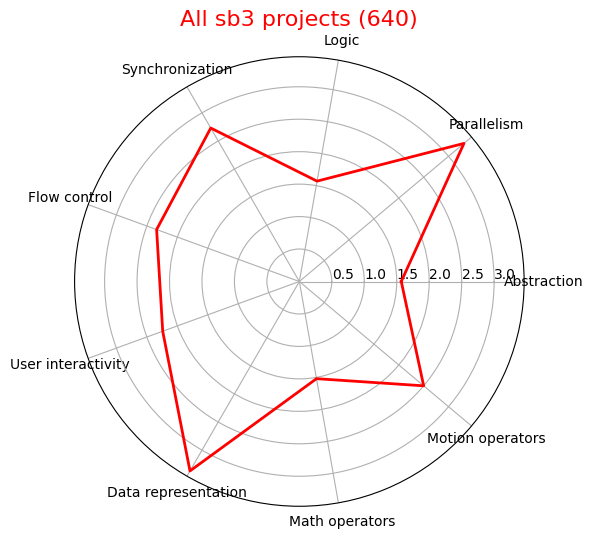

In [19]:
# CHOOSE DATAFRAME
df = metrics_attr
# DATA PREPROCESSING
dims = df.iloc[:, 8:17]
dims_names = dims.columns.tolist()
dim_means = dims.mean()
dim_means = dim_means.tolist()
dim_means = [round(n,2) for n in dim_means]

# ADAPTIONS TO GRAPH NAMES
cat = dims_names
val = dim_means

# GRAPH
num_vars = len(cat)
angles = [n * 2 * np.pi / num_vars for n in range(num_vars)]
angles += angles[:1]
val += val[:1]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, val, color='r', linewidth=2)  
ax.set_rlabel_position(0)  

# DESIGN
plt.title("All sb3 projects (640)", fontsize=16, color='red')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dims)

# ADJUST DESIGN
plt.tight_layout()

# SHOW GRAPH
plt.show()

#### 6.1.2. Main Genre

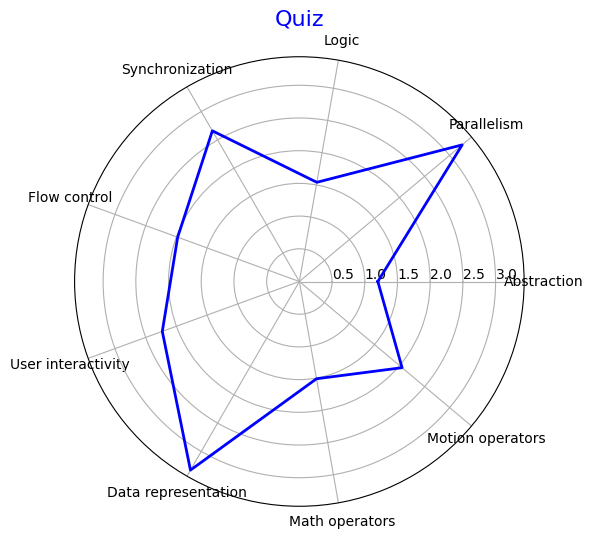

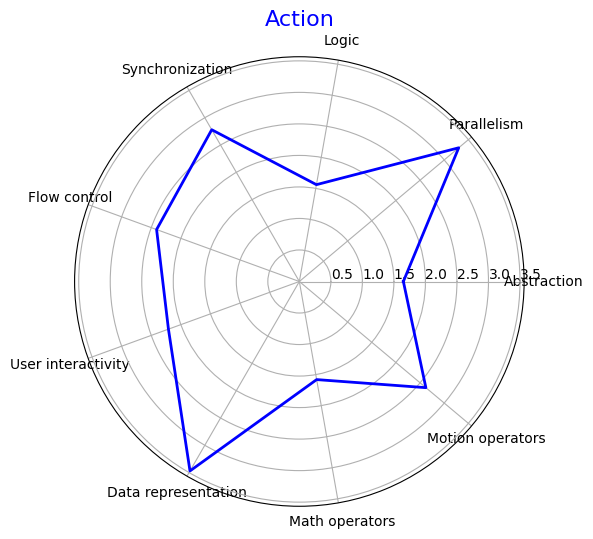

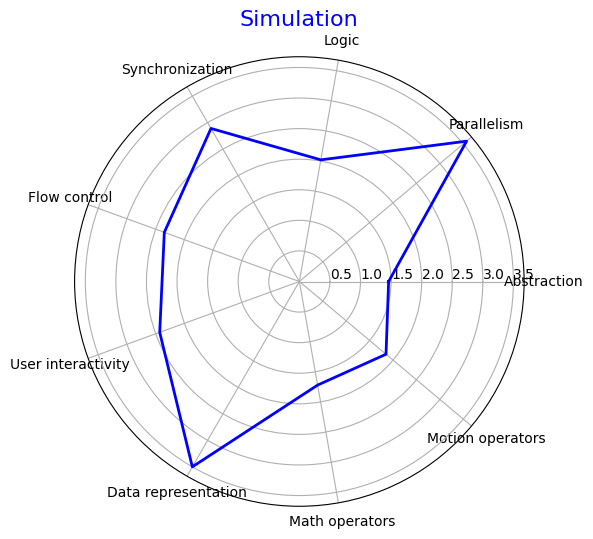

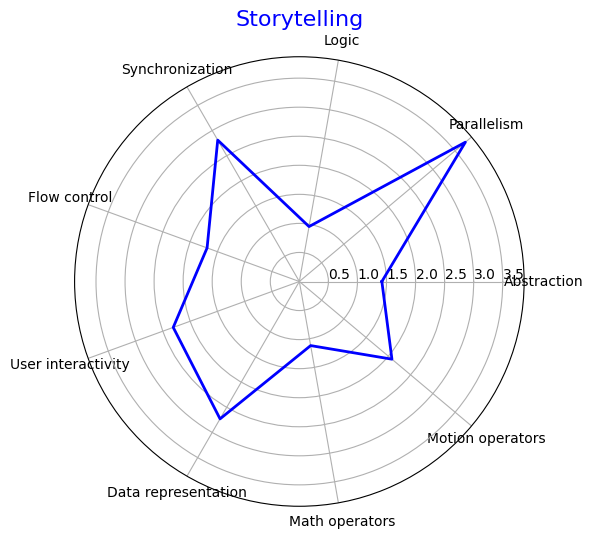

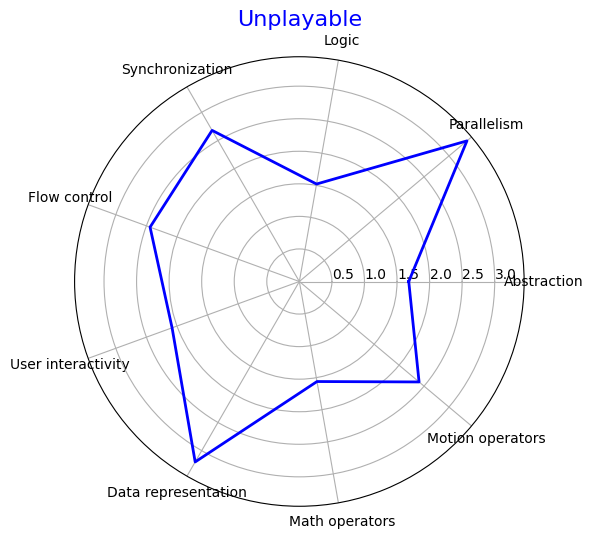

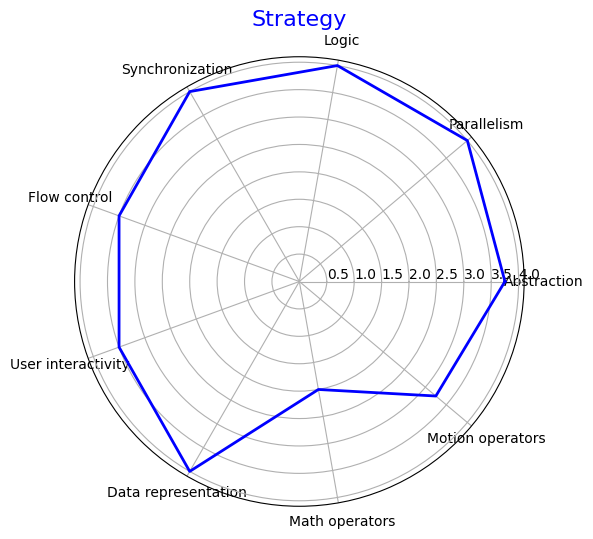

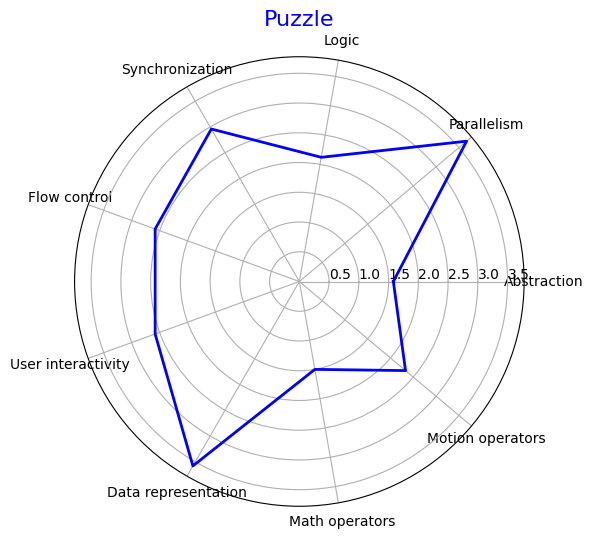

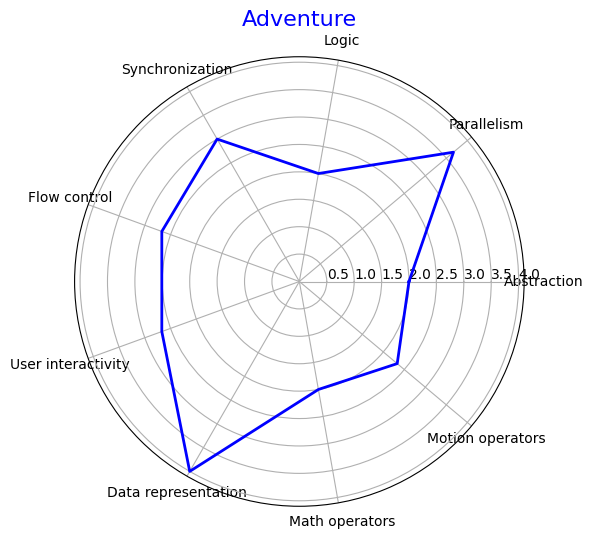

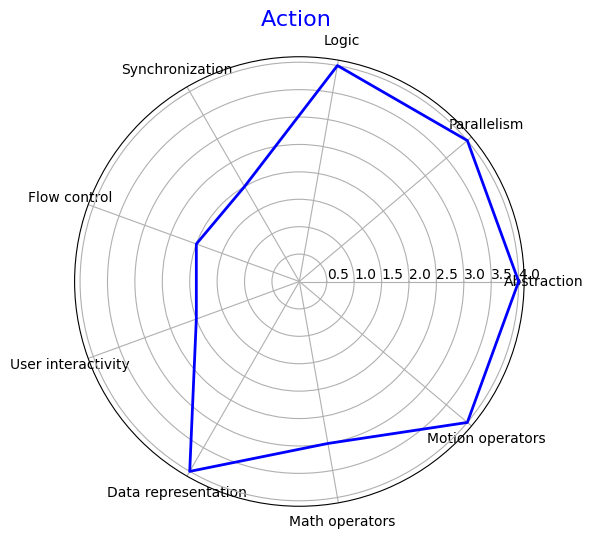

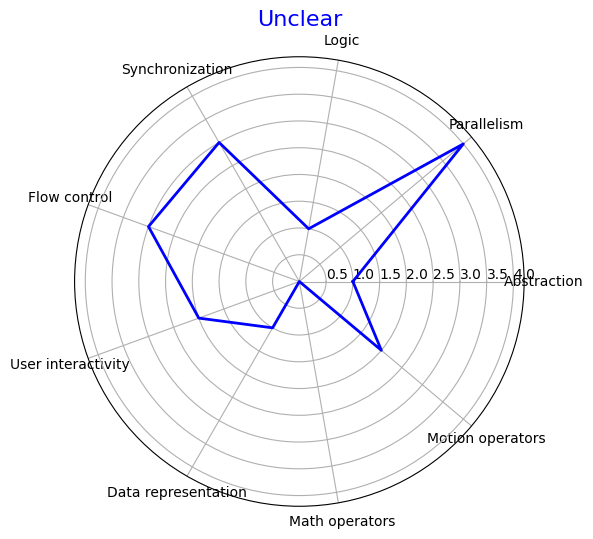

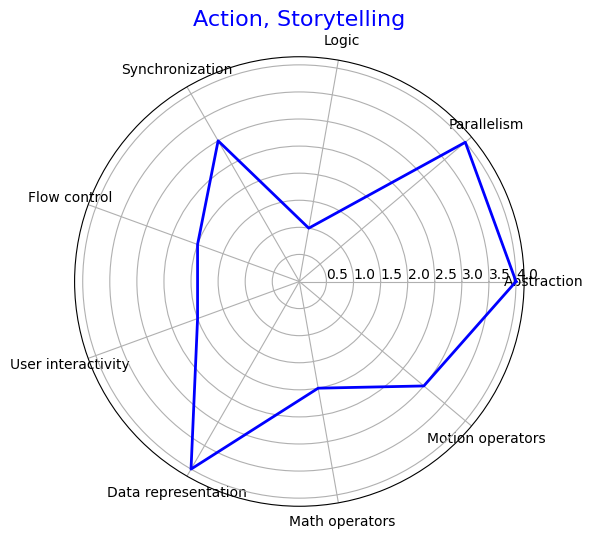

In [20]:
# CHOOSE DATAFRAME
for name, df in main_genres_subsets.items():
    # DATA PREPROCESSING
    dims = df.iloc[:, 8:17]
    dims_names = dims.columns.tolist()
    dim_means = dims.mean()
    dim_means = dim_means.tolist()
    dim_means = [round(n,2) for n in dim_means]
    
    # ADAPTIONS TO GRAPH NAMES
    cat = dims_names
    val = dim_means
    
    # GRAPH
    num_vars = len(cat)
    angles = [n * 2 * np.pi / num_vars for n in range(num_vars)]
    angles += angles[:1]
    val += val[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, val, color='b', linewidth=2)  
    ax.set_rlabel_position(0)  
    
    # DESIGN
    plt.title(name, fontsize=16, color='blue')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dims)

    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        pass

    
    # ADJUST DESIGN
    plt.tight_layout()

    # SHOW GRAPH
    plt.show()

#### 6.1.3 Second Genre

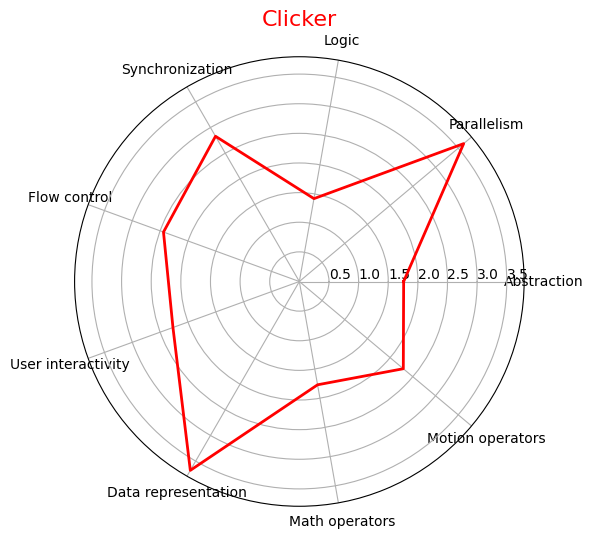

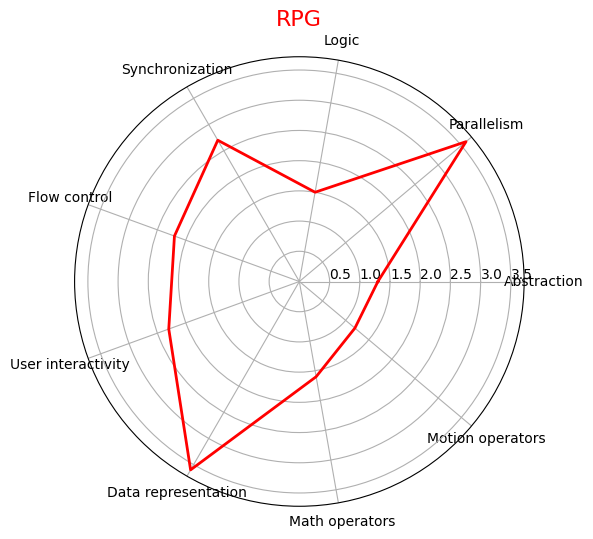

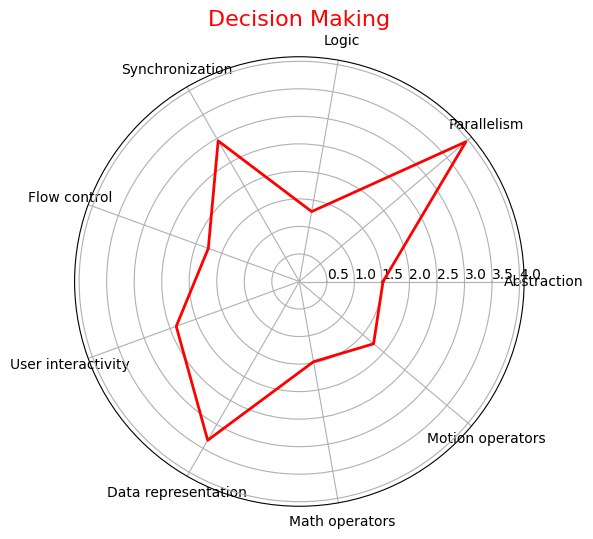

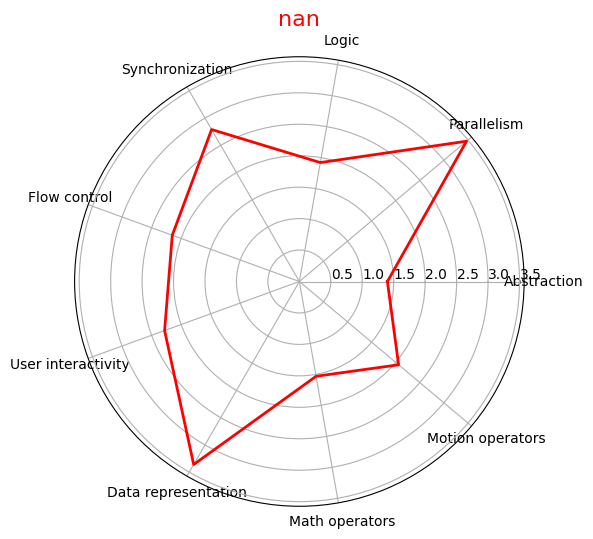

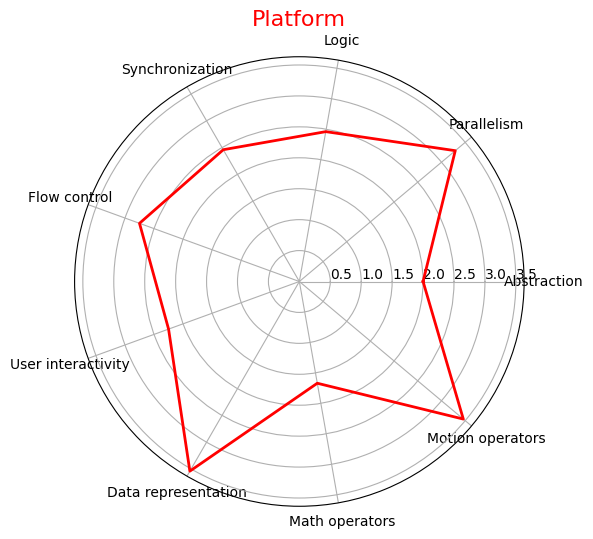

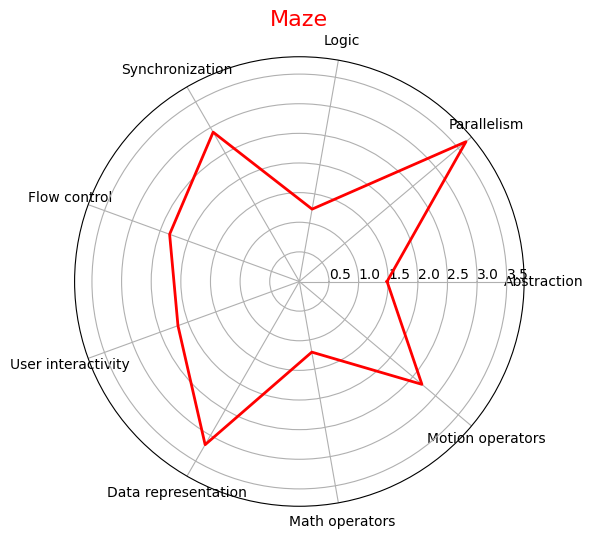

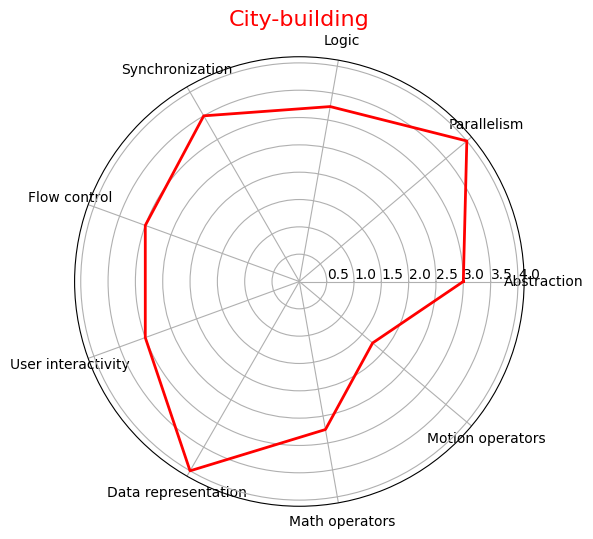

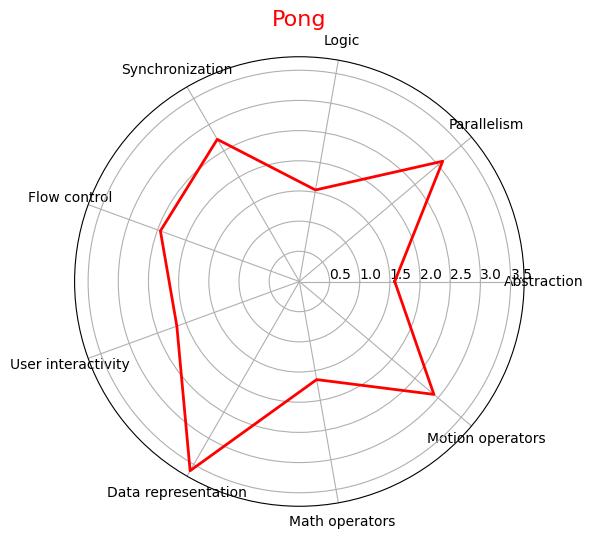

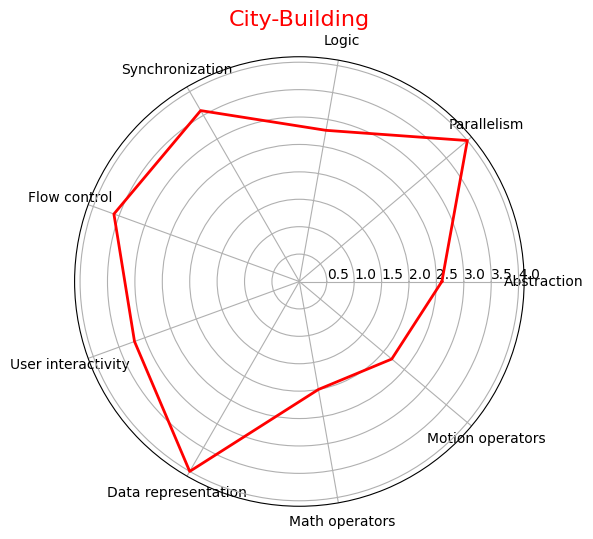

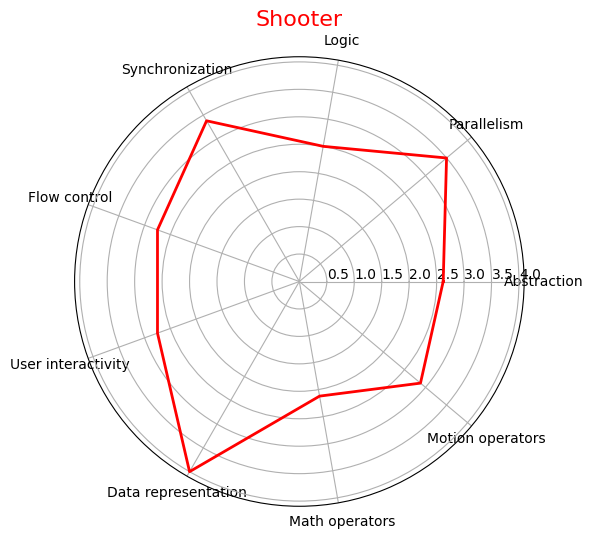

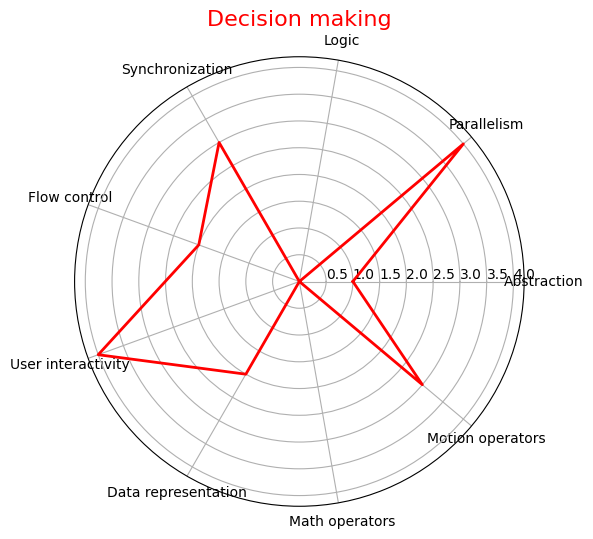

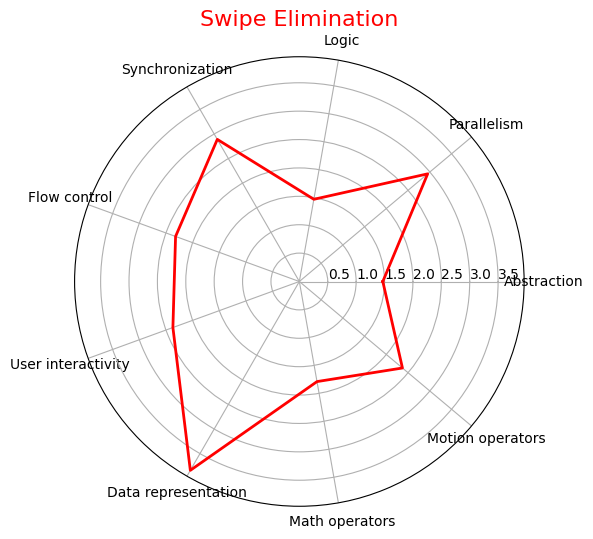

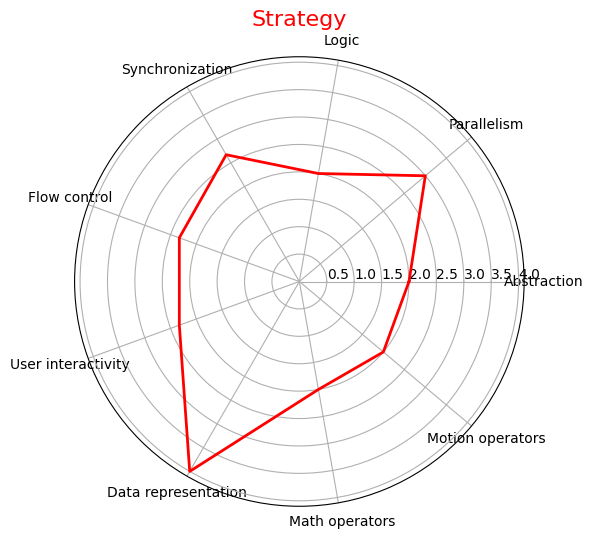

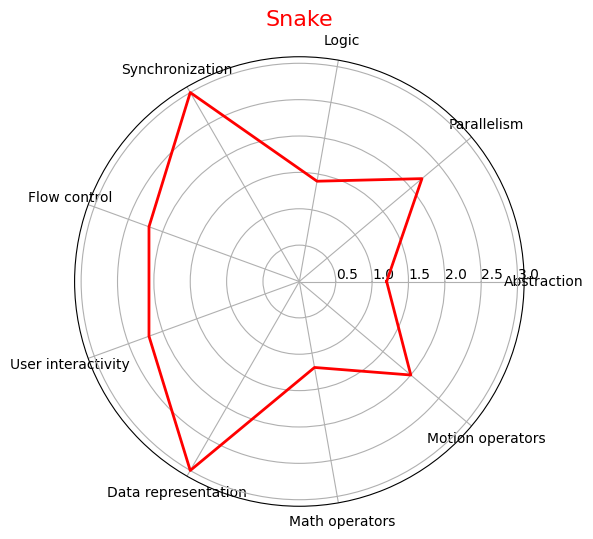

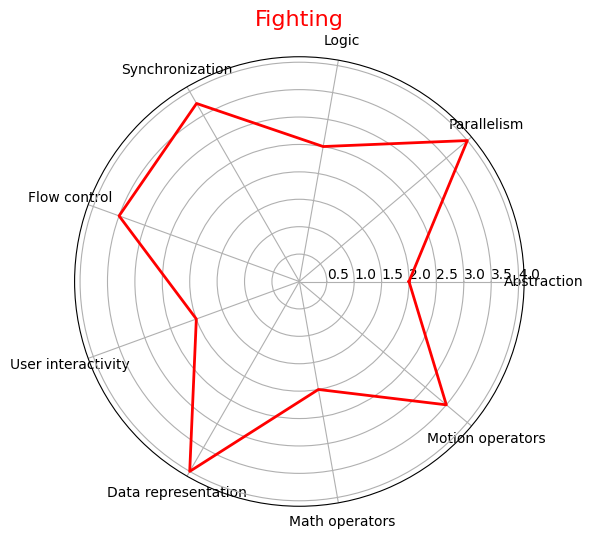

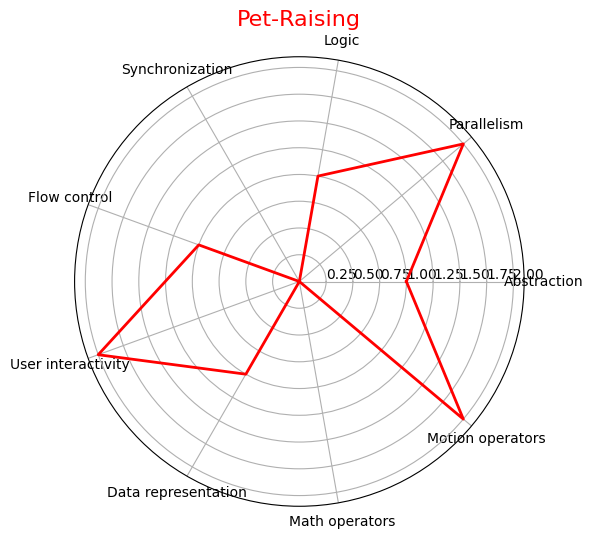

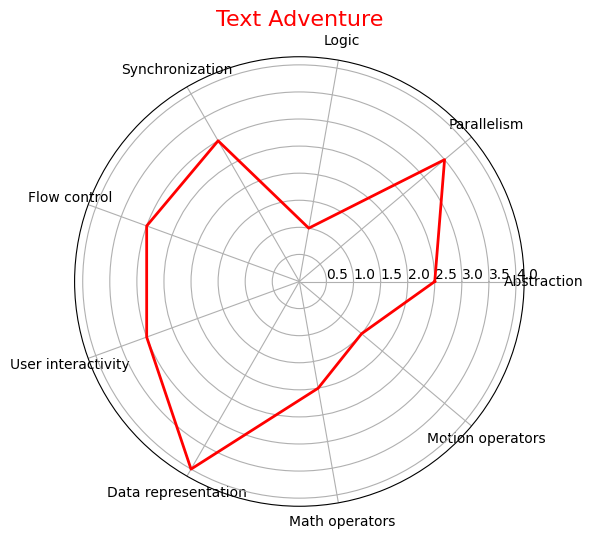

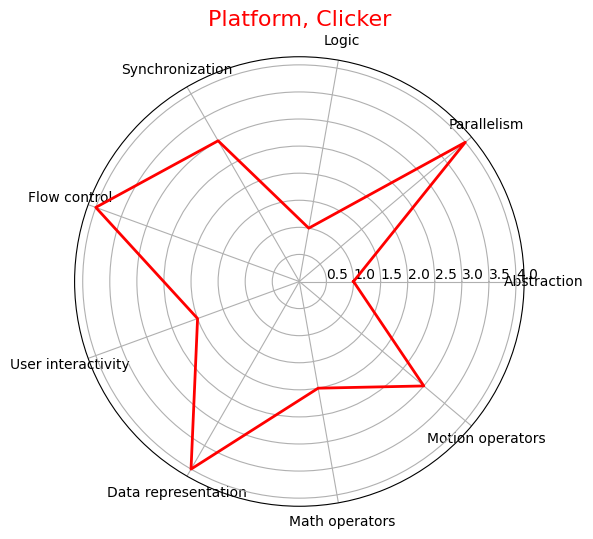

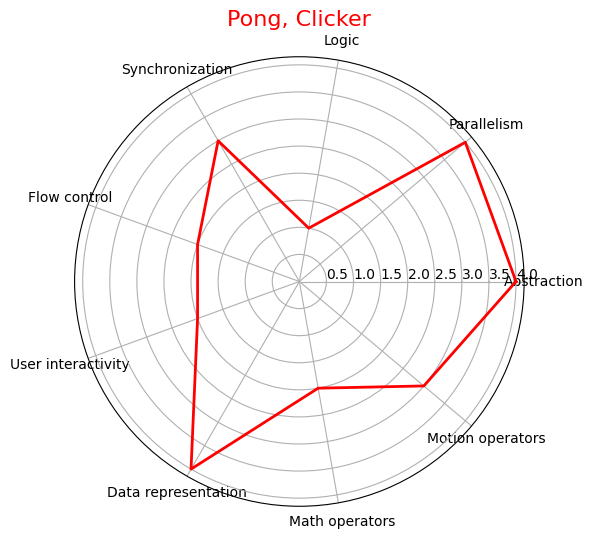

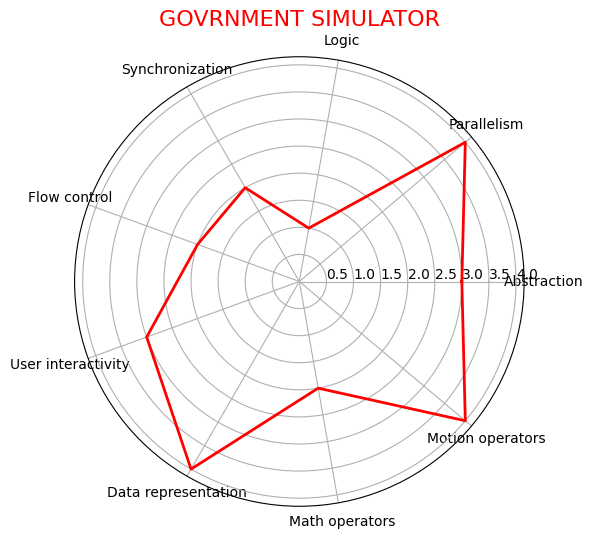

In [21]:
# CHOOSE DATAFRAME
for name, df in second_genres_subsets.items():
    # DATA PREPROCESSING
    dims = df.iloc[:, 8:17]
    dims_names = dims.columns.tolist()
    dim_means = dims.mean()
    dim_means = dim_means.tolist()
    dim_means = [round(n,2) for n in dim_means]
    
    # ADAPTIONS TO GRAPH NAMES
    cat = dims_names
    val = dim_means
    
    # GRAPH
    num_vars = len(cat)
    angles = [n * 2 * np.pi / num_vars for n in range(num_vars)]
    angles += angles[:1]
    val += val[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, val, color='r', linewidth=2)  
    ax.set_rlabel_position(0)  
    
    # DESIGN
    plt.title(name, fontsize=16, color='red')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dims)
    
    # ADJUST DESIGN
    plt.tight_layout()
    
    # SHOW GRAPH
    plt.show()

### 6.2 Graph **Heat map**

#### 6.2.1 All projects

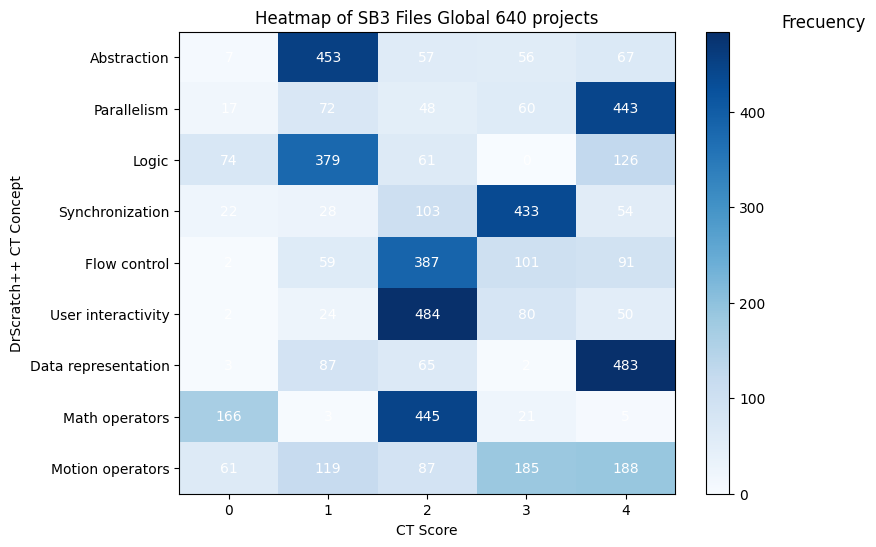

In [22]:
from collections import Counter

df = metrics_attr
df = df.iloc[:,8:17]

dims_names = df.columns[0:12].tolist()
# CREATION OF FRECUENCY MATRIX
counter_list = [Counter(df[dim]) for dim in dims_names]
max_value = 5
matrix = np.zeros((len(dims_names), 5))
for y, counter in enumerate(counter_list):
    for x in range(max_value):
        matrix[y, x]= counter.get(x, 0)

# PLOT OF GRAPH
plt.figure(figsize=(8, 6)) 
plt.imshow(matrix, cmap='Blues', interpolation='nearest', aspect='auto')
plt.yticks([n for n in range(len(dims_names))], dims_names)
plt.colorbar()

# SHOW NUMERIC VALUE IN EACH HEATMAP CELL
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = int(matrix[i, j])
        plt.text(j, i, val, ha='center', va='center', color='white')

# DESIGN
plt.title(f'Heatmap of SB3 Files Global {metrics_attr.shape[0]} projects')
plt.xlabel('CT Score')
plt.ylabel('DrScratch++ CT Concept')
plt.text(1.3, 1.02, 'Frecuency', fontsize=12, ha='center', va='center', rotation=0, transform=plt.gca().transAxes)


plt.show()

#### 6.2.2 Main Genre

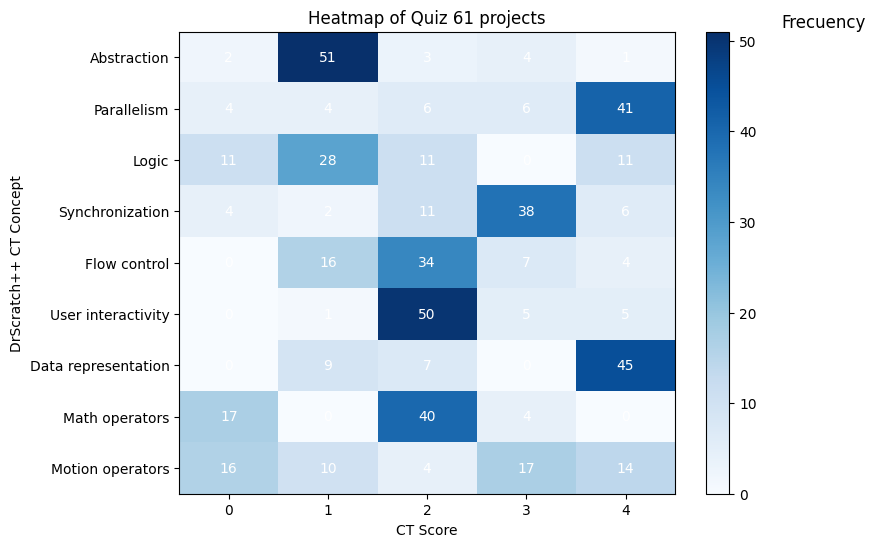

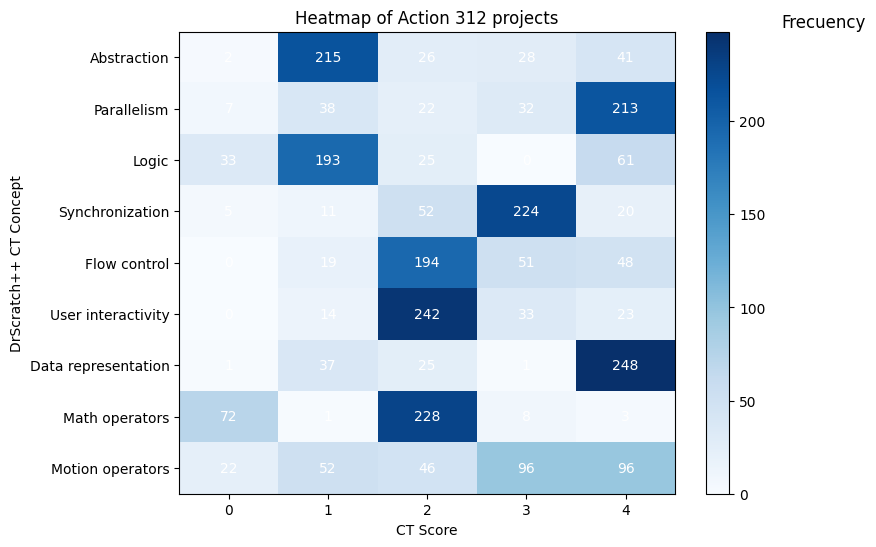

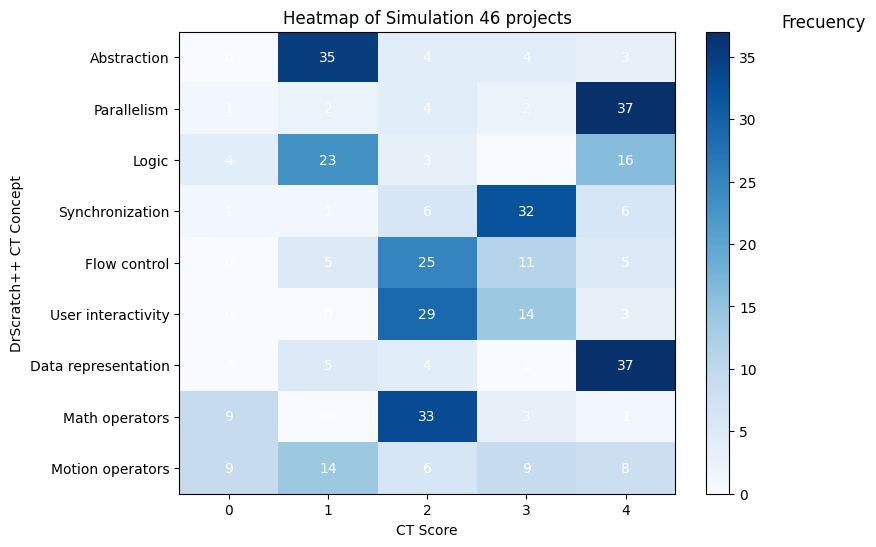

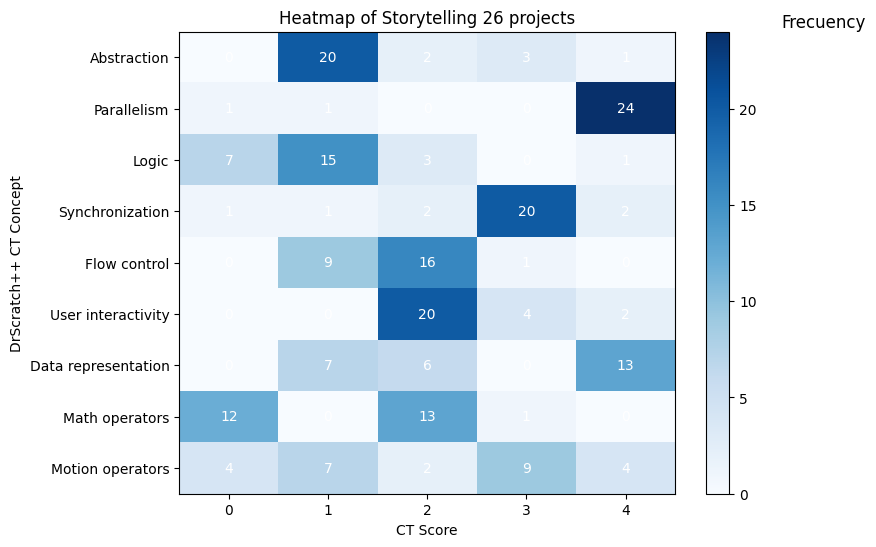

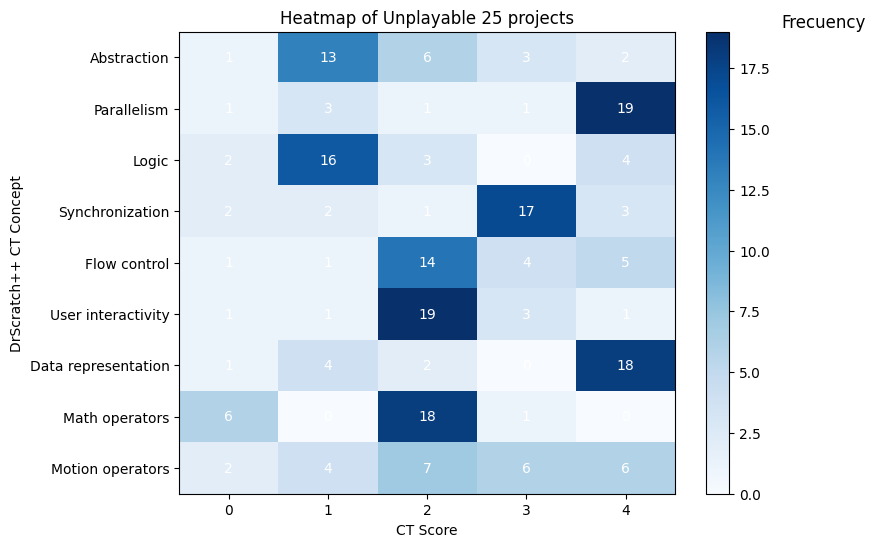

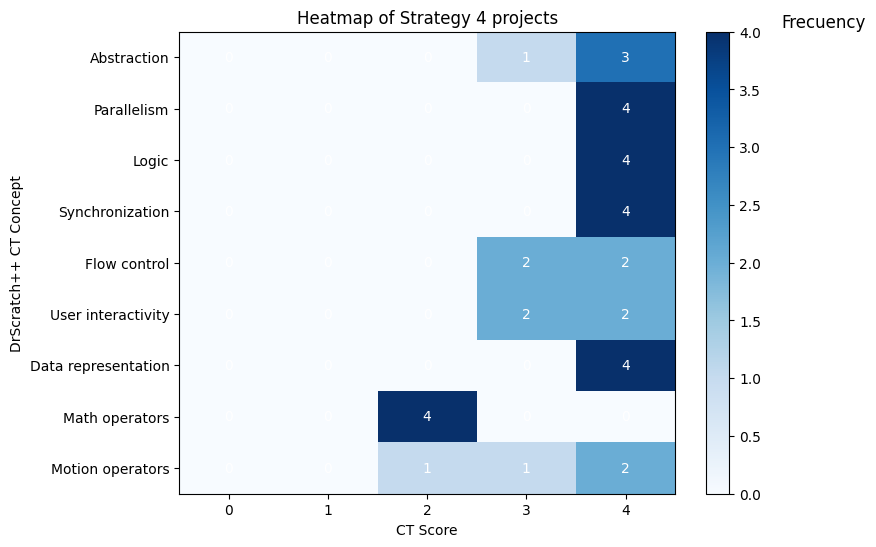

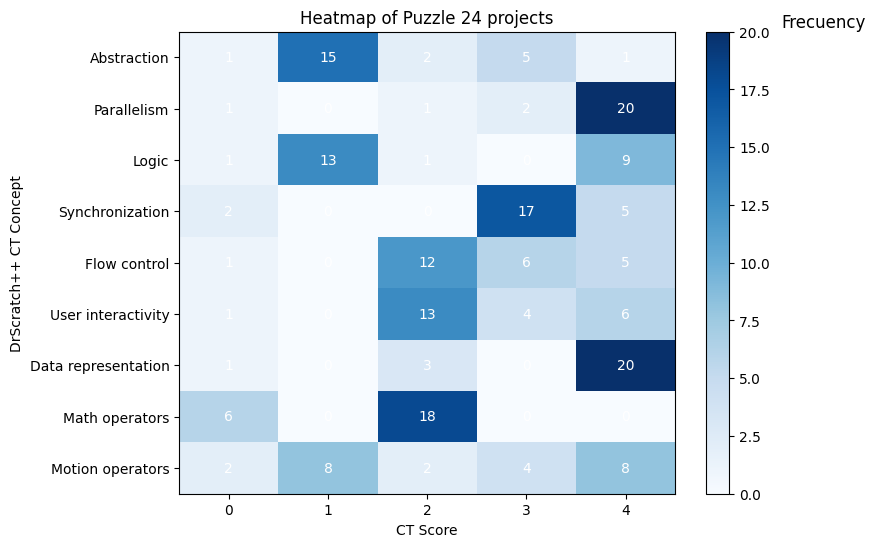

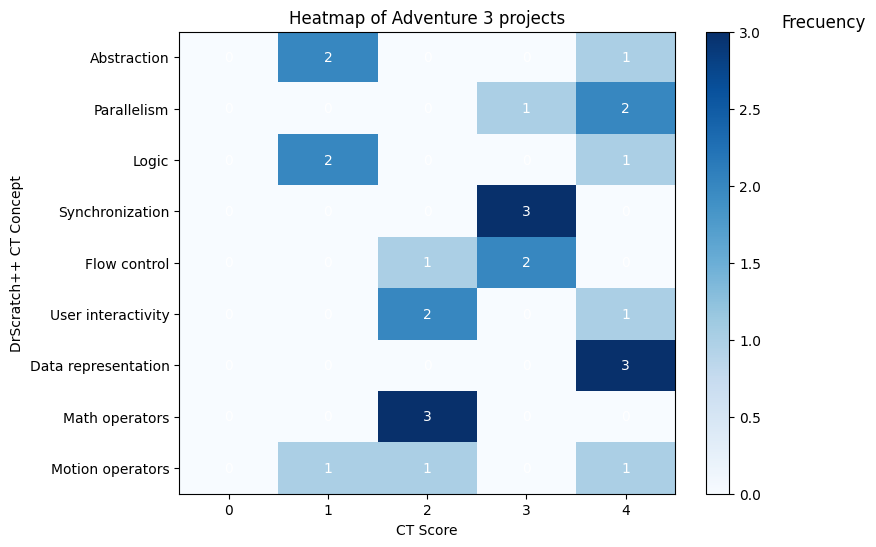

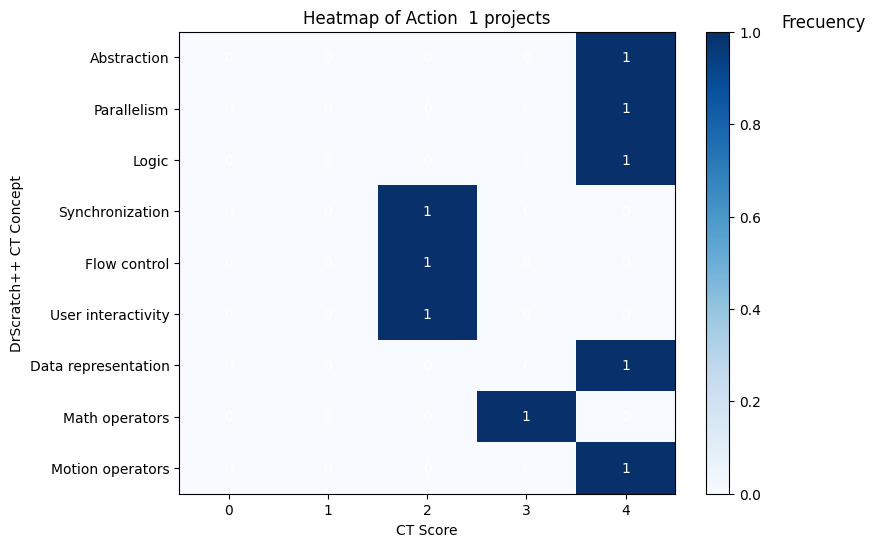

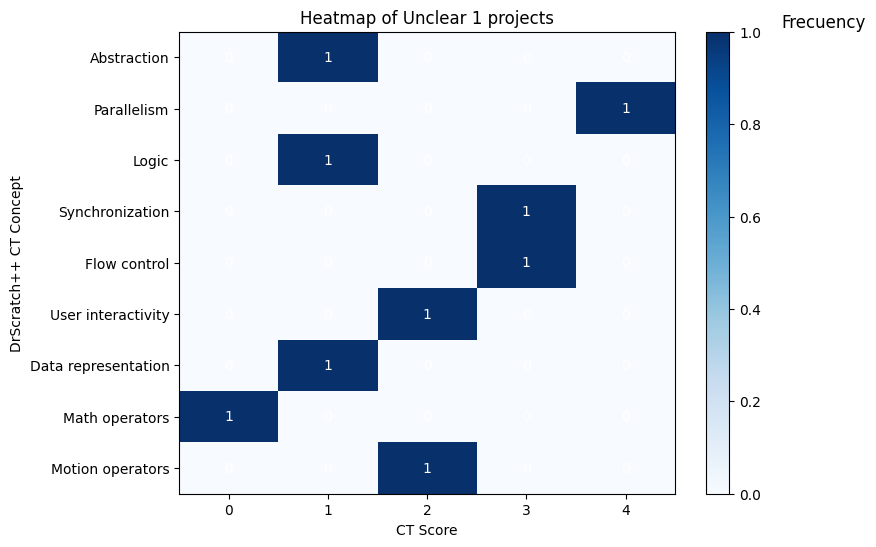

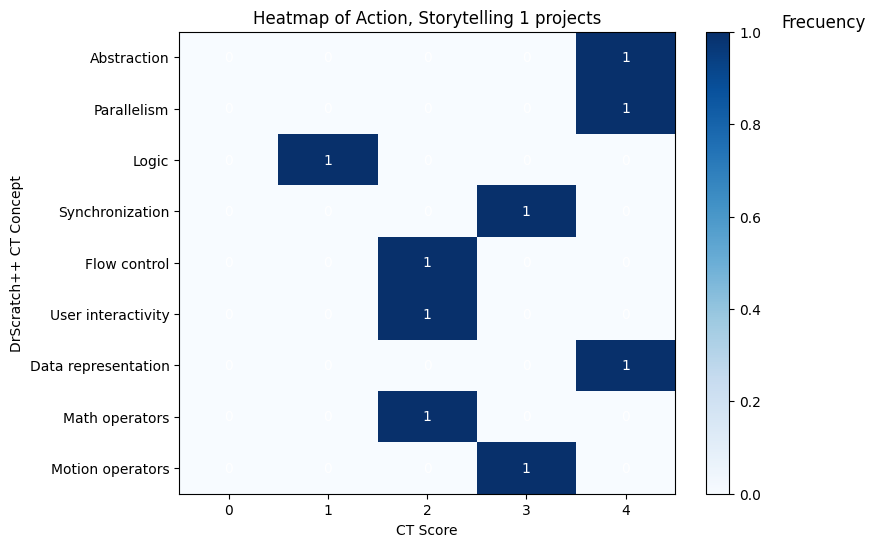

In [23]:
from collections import Counter

for name, df in main_genres_subsets.items():
    df = df.iloc[:,8:17]
    
    dims_names = df.columns[0:12].tolist()
    # CREATION OF FRECUENCY MATRIX
    counter_list = [Counter(df[dim]) for dim in dims_names]
    max_value = 5
    matrix = np.zeros((len(dims_names), 5))
    for y, counter in enumerate(counter_list):
        for x in range(max_value):
            matrix[y, x]= counter.get(x, 0)
    
    # PLOT OF GRAPH
    plt.figure(figsize=(8, 6)) 
    plt.imshow(matrix, cmap='Blues', interpolation='nearest', aspect='auto')
    plt.yticks([n for n in range(len(dims_names))], dims_names)
    plt.colorbar()
    
    # SHOW NUMERIC VALUE IN EACH HEATMAP CELL
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = int(matrix[i, j])
            plt.text(j, i, val, ha='center', va='center', color='white')
    
    # DESIGN
    plt.title(f'Heatmap of {name} {df.shape[0]} projects')
    plt.xlabel('CT Score')
    plt.ylabel('DrScratch++ CT Concept')
    plt.text(1.3, 1.02, 'Frecuency', fontsize=12, ha='center', va='center', rotation=0, transform=plt.gca().transAxes)
    
    
    plt.show()

#### 6.2.3 Second Genre

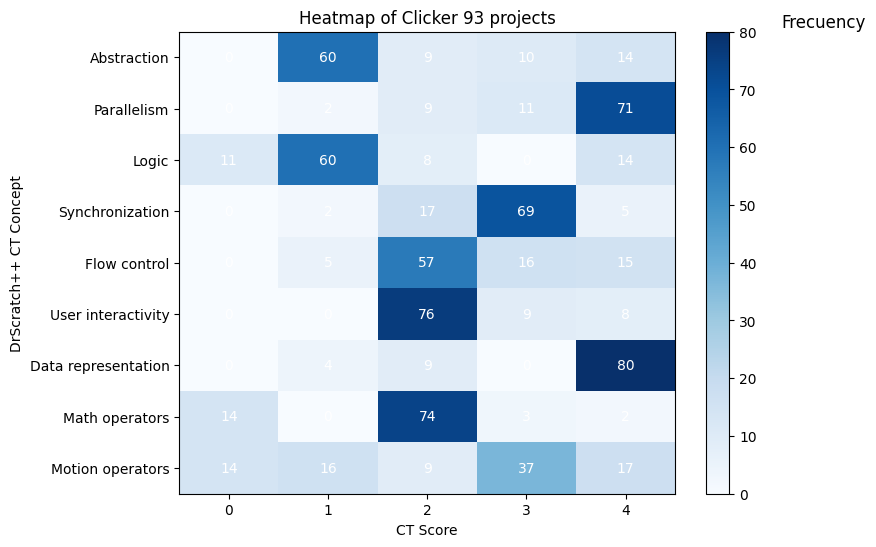

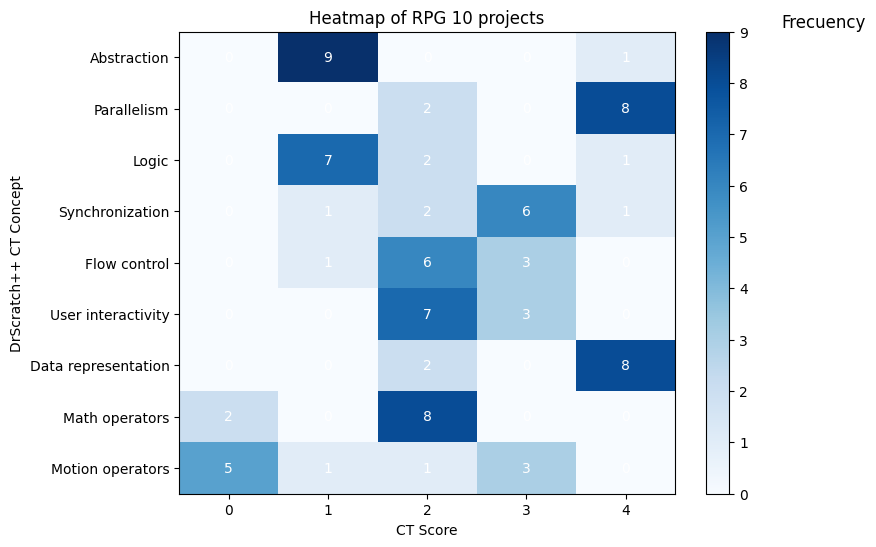

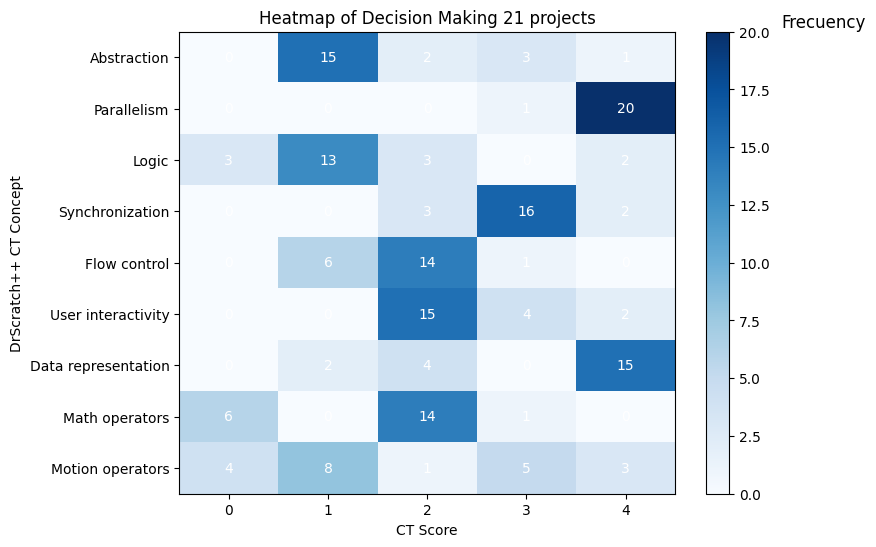

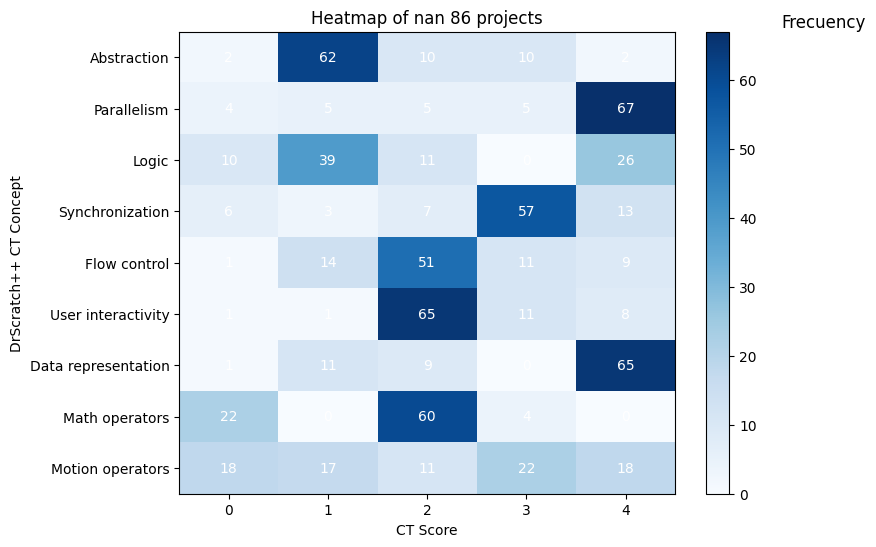

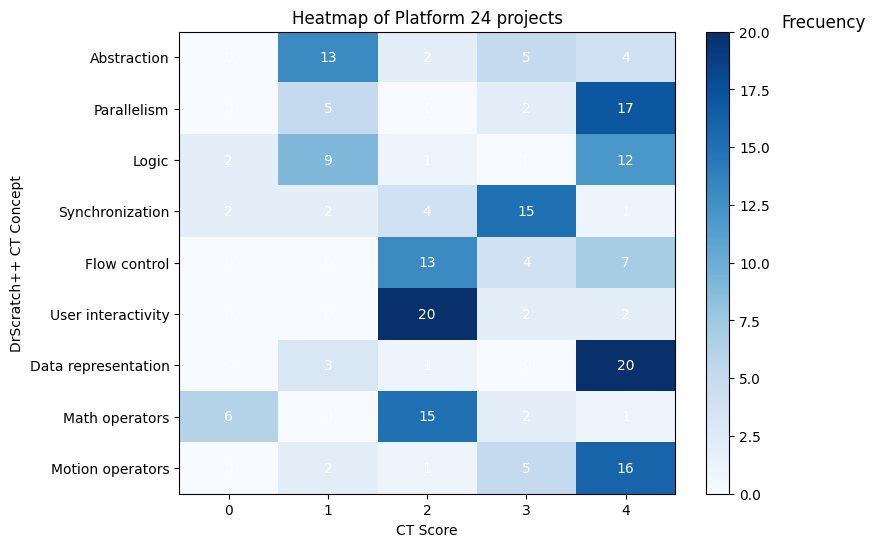

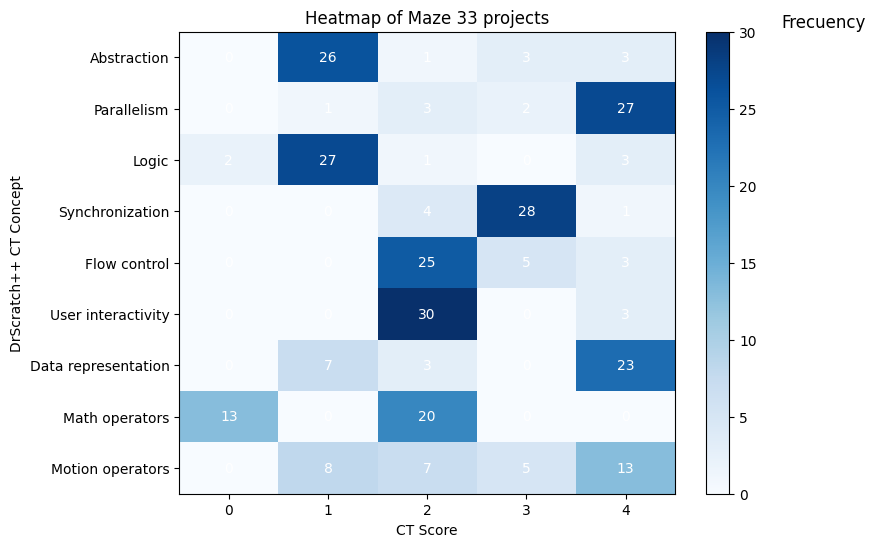

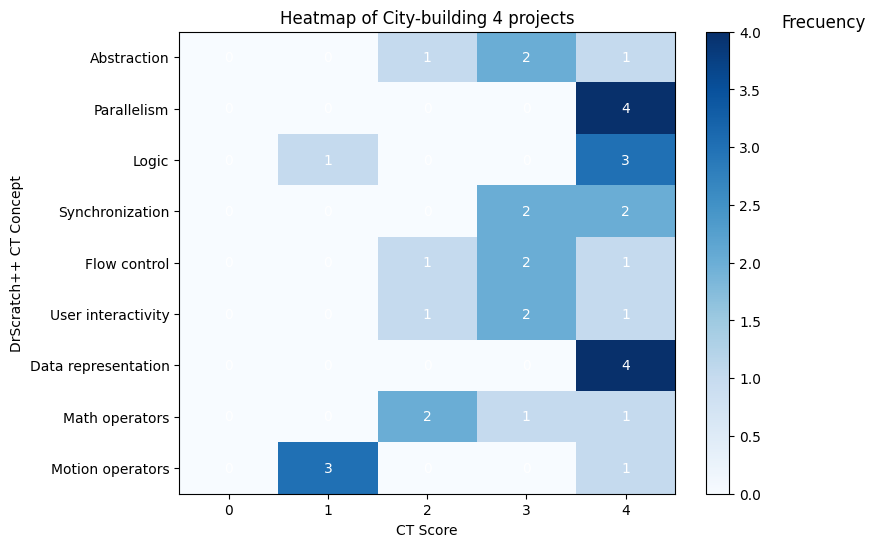

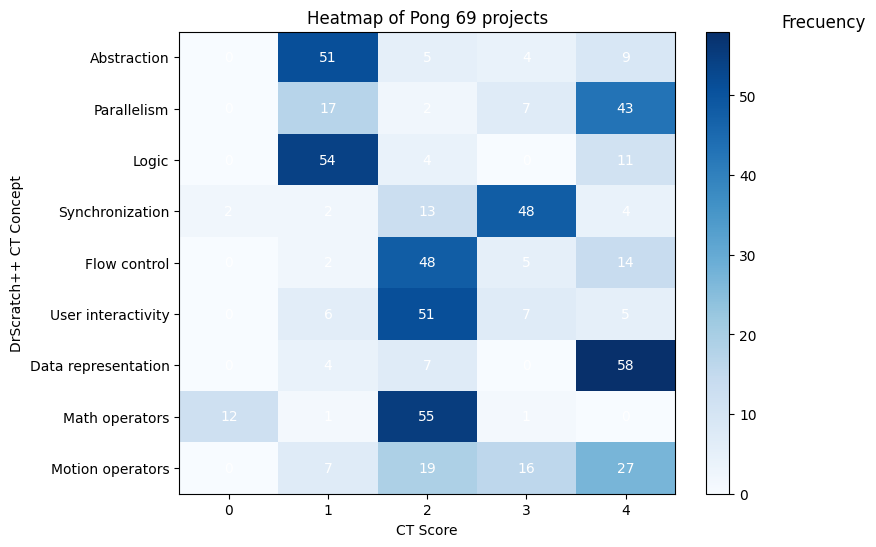

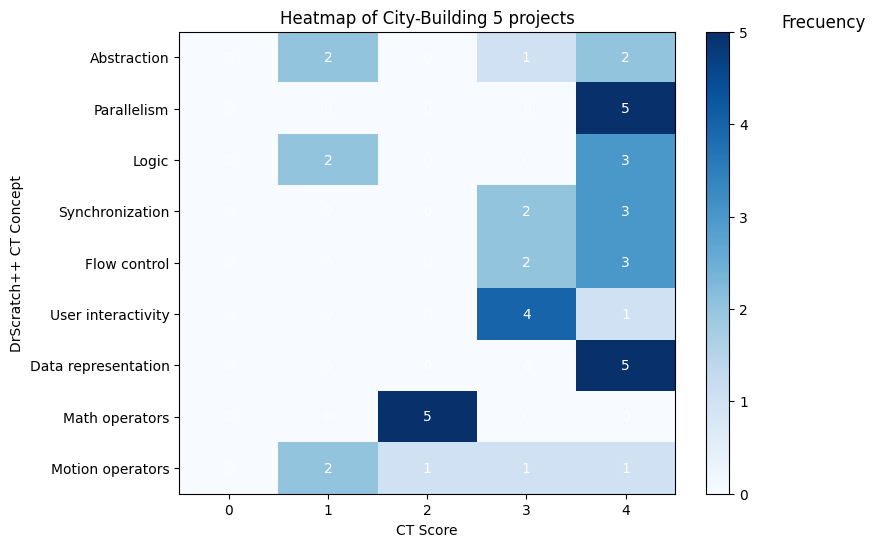

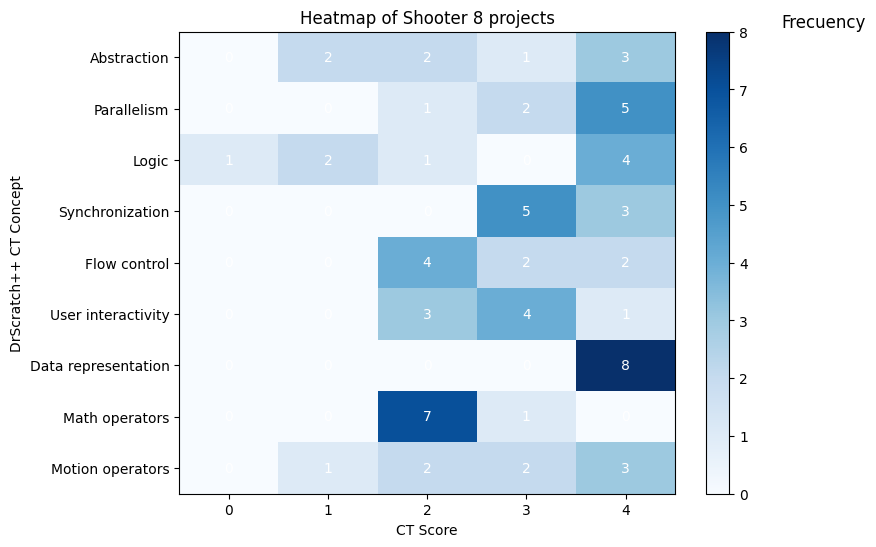

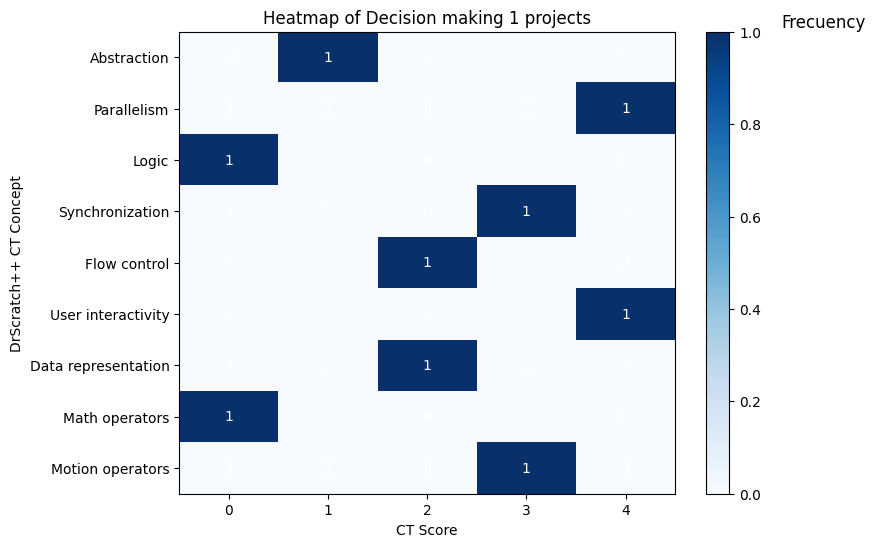

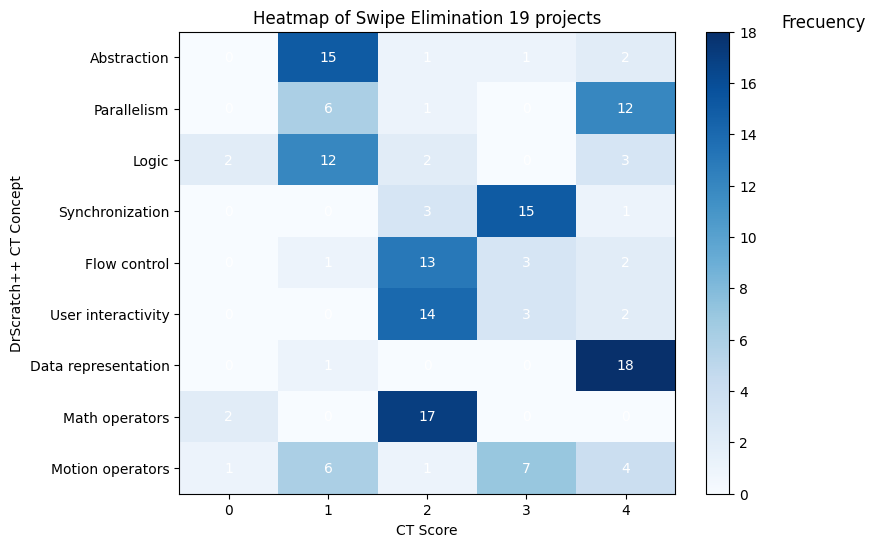

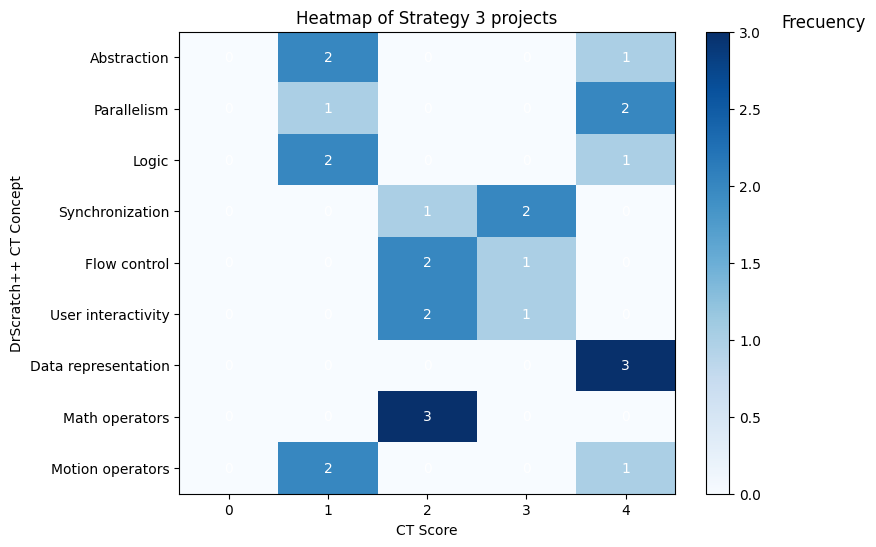

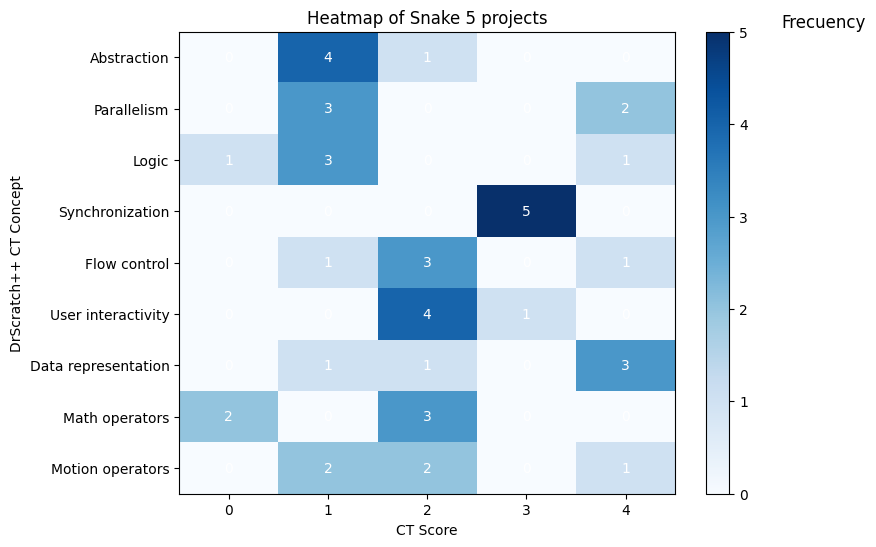

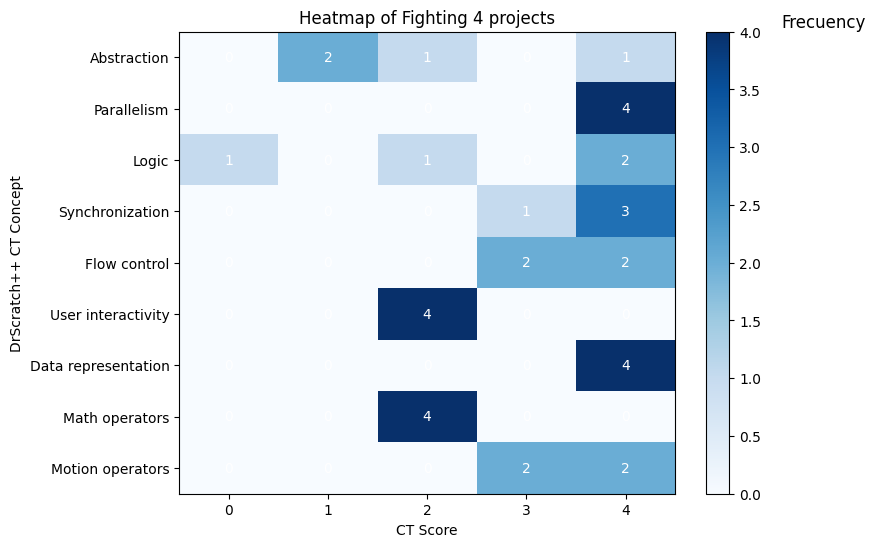

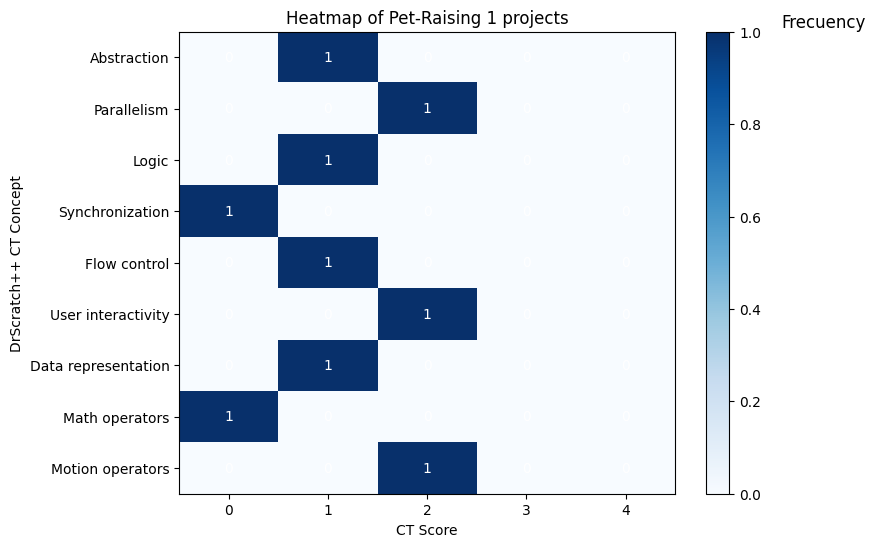

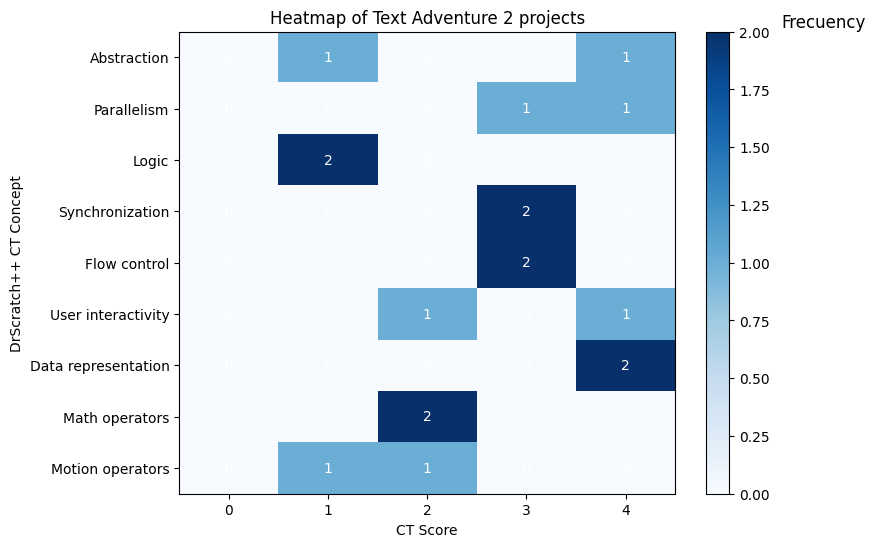

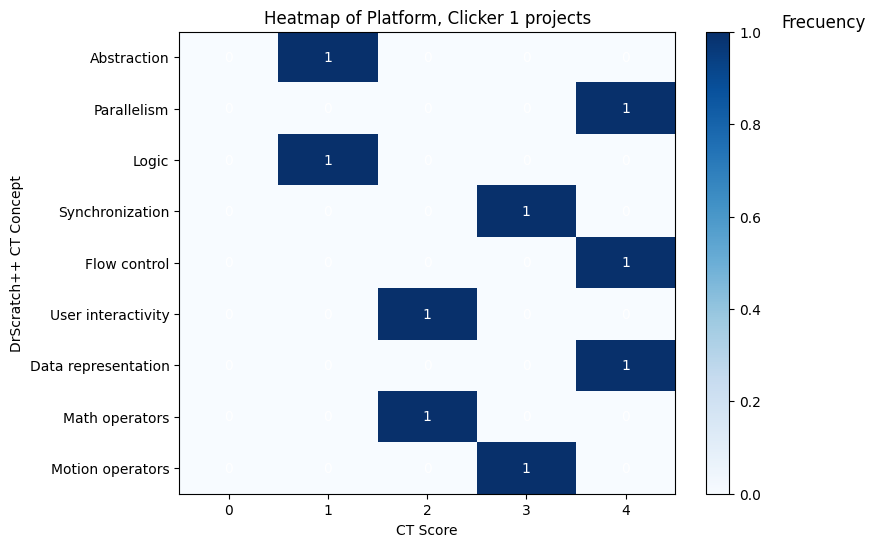

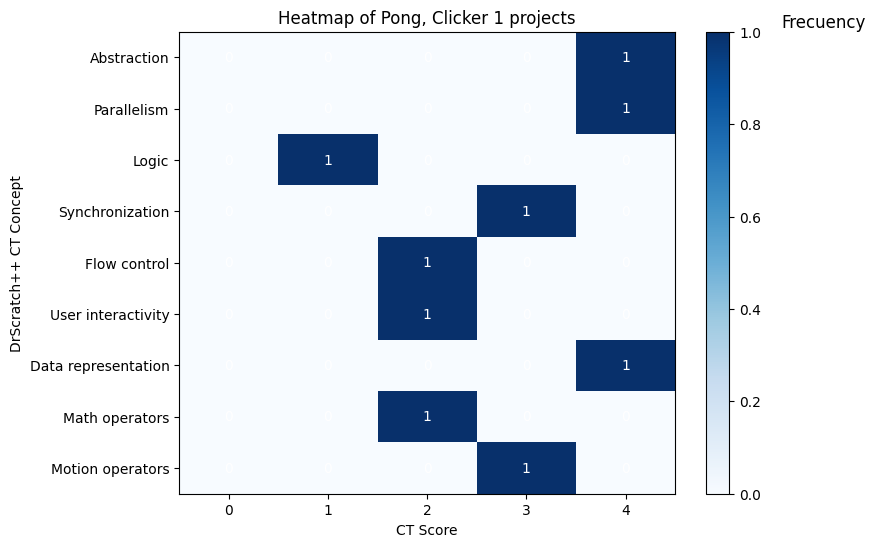

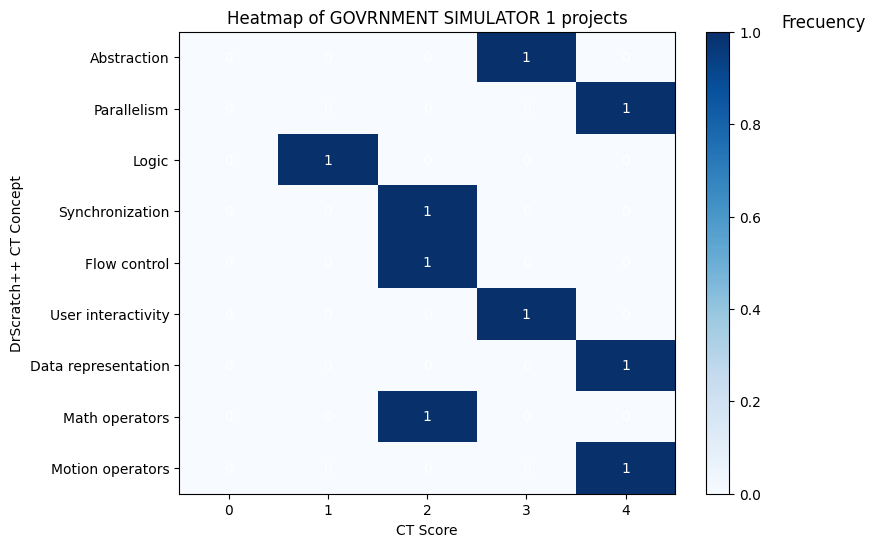

In [24]:
for name, df in second_genres_subsets.items():
    df = df.iloc[:,8:17]
    
    dims_names = df.columns[0:12].tolist()
    # CREATION OF FRECUENCY MATRIX
    counter_list = [Counter(df[dim]) for dim in dims_names]
    max_value = 5
    matrix = np.zeros((len(dims_names), 5))
    for y, counter in enumerate(counter_list):
        for x in range(max_value):
            matrix[y, x]= counter.get(x, 0)
    
    # PLOT OF GRAPH
    plt.figure(figsize=(8, 6)) 
    plt.imshow(matrix, cmap='Blues', interpolation='nearest', aspect='auto')
    plt.yticks([n for n in range(len(dims_names))], dims_names)
    plt.colorbar()
    
    # SHOW NUMERIC VALUE IN EACH HEATMAP CELL
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = int(matrix[i, j])
            plt.text(j, i, val, ha='center', va='center', color='white')
    
    # DESIGN
    plt.title(f'Heatmap of {name} {df.shape[0]} projects')
    plt.xlabel('CT Score')
    plt.ylabel('DrScratch++ CT Concept')
    plt.text(1.3, 1.02, 'Frecuency', fontsize=12, ha='center', va='center', rotation=0, transform=plt.gca().transAxes)
    
    
    plt.show()

### 6.3. Graph **Histograms and KDE Plots**

#### 6.3.1. All projects

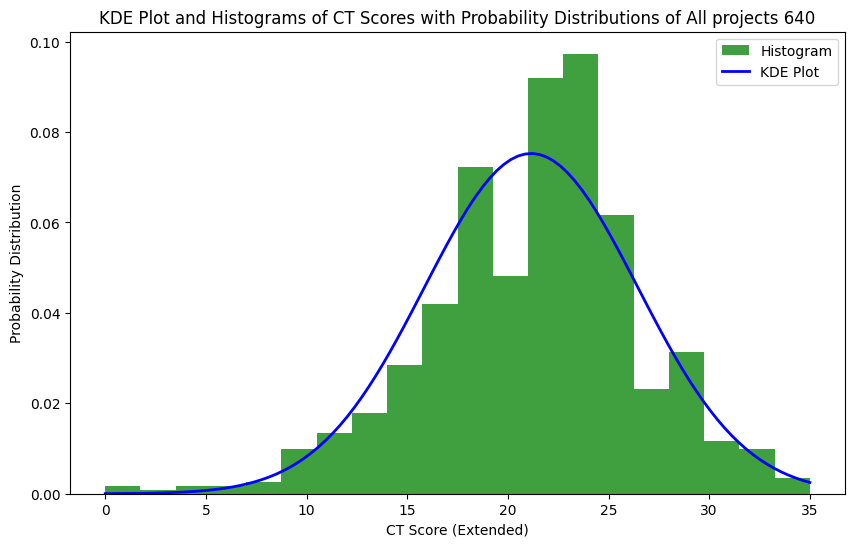

In [25]:
df = metrics_attr
ct_score = df['points']

# Gauss bell and save in a dataframe
mean = ct_score.mean()
std_dev = ct_score.std()
min_score = ct_score.min()
max_score = ct_score.max()
x = np.linspace(min_score, max_score, 100)
pdf = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))


plt.figure(figsize=(10, 6))

# HISTOGRAM OF CT Score
plt.hist(ct_score, density=True, color='green',bins=20, alpha=0.75, label='Histogram')

# NORMAL DISTRIBUTION
plt.plot(x, pdf, color='blue', linewidth=2, label='KDE Plot')


# DESIGN
plt.title(f"KDE Plot and Histograms of CT Scores with Probability Distributions of All projects {df.shape[0]}")
plt.xlabel('CT Score (Extended)')
plt.ylabel('Probability Distribution')
plt.legend()


plt.show()

#### 6.3.1. Main Genre

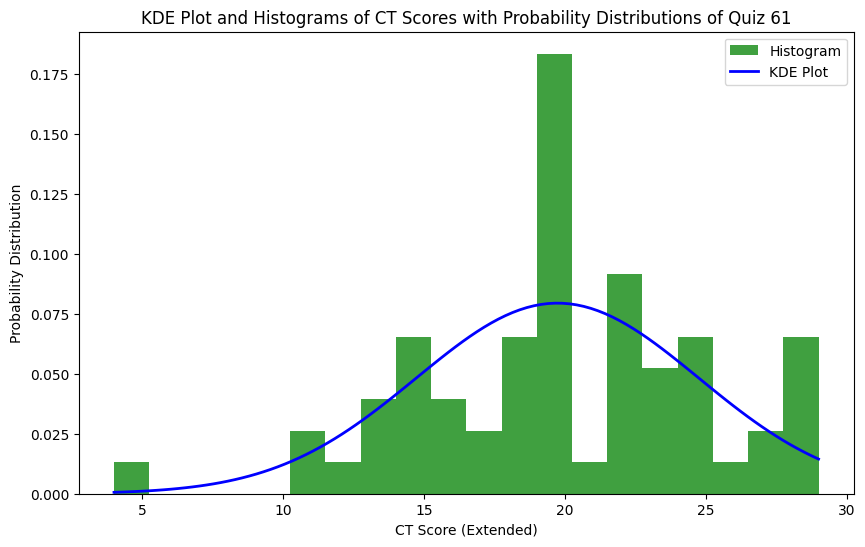

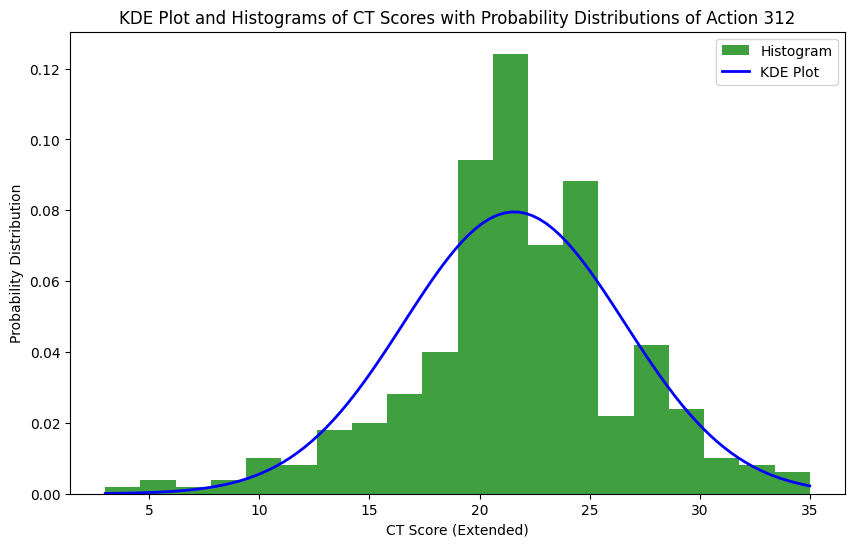

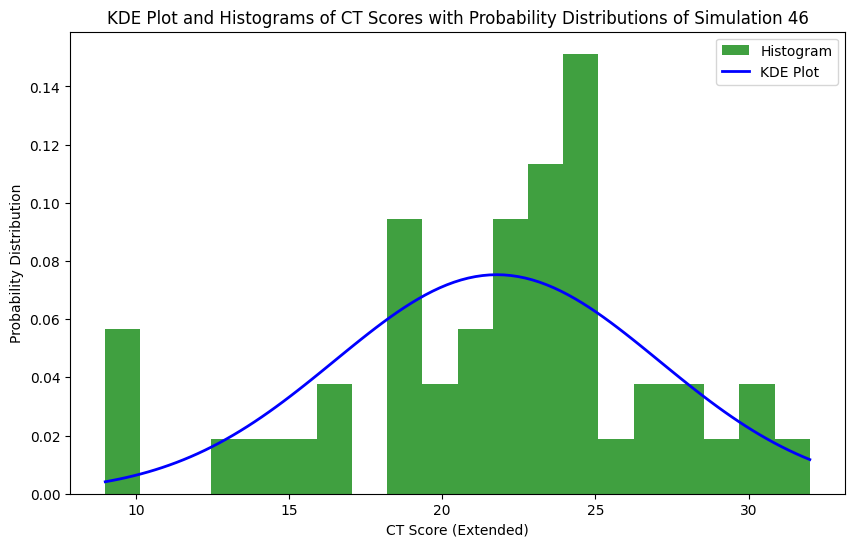

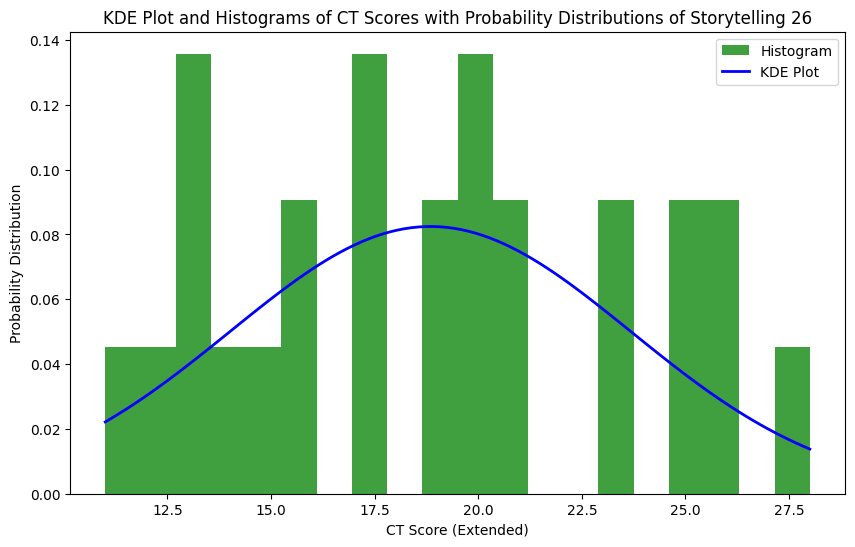

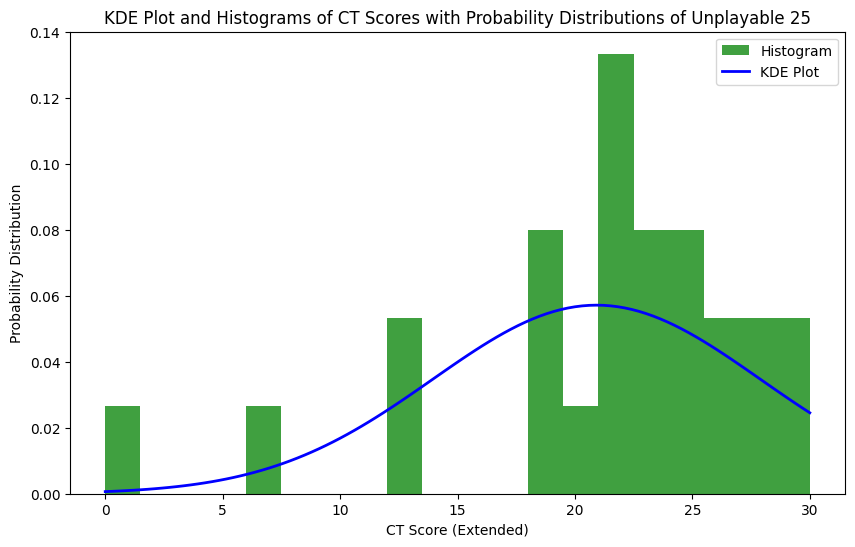

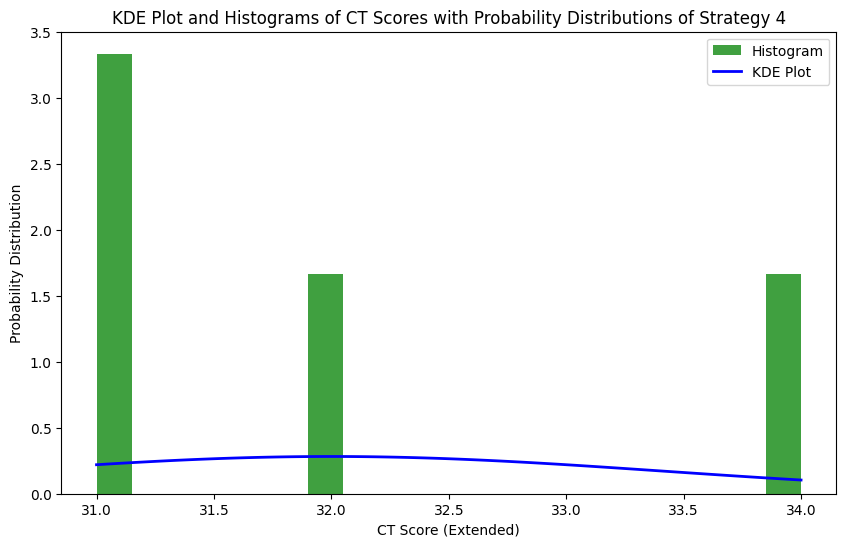

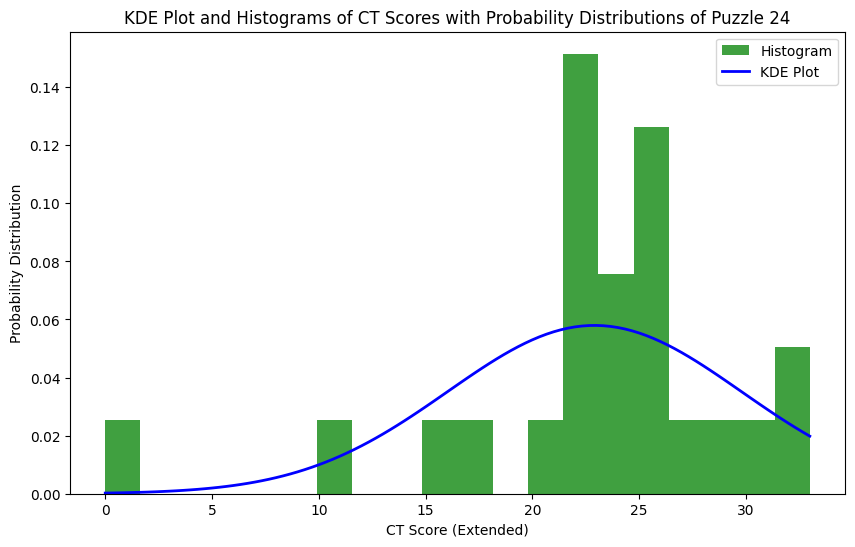

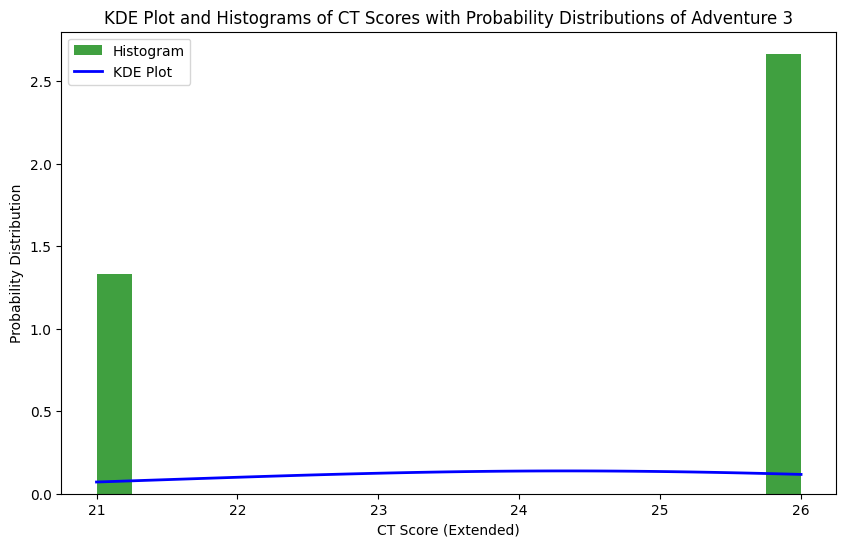

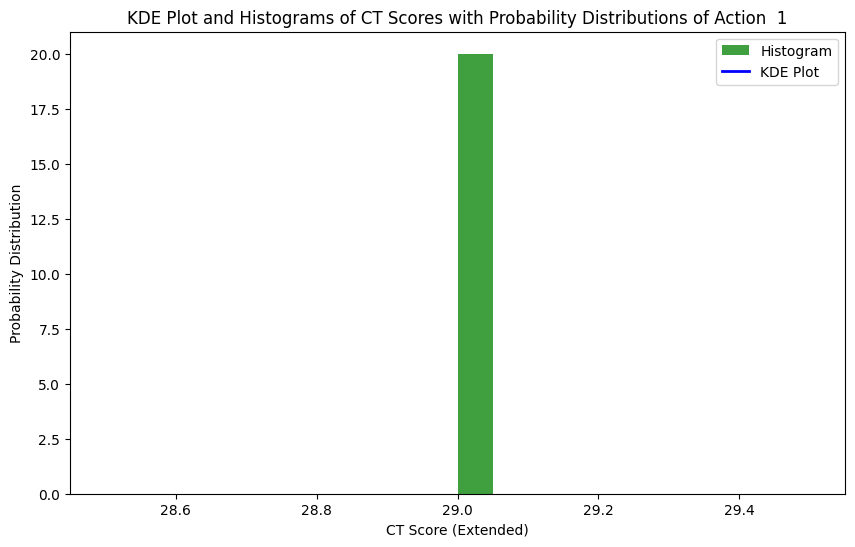

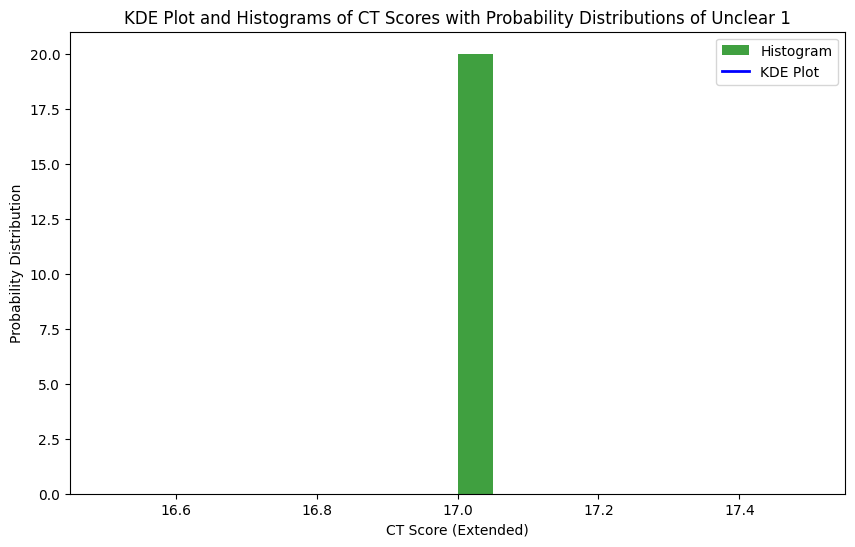

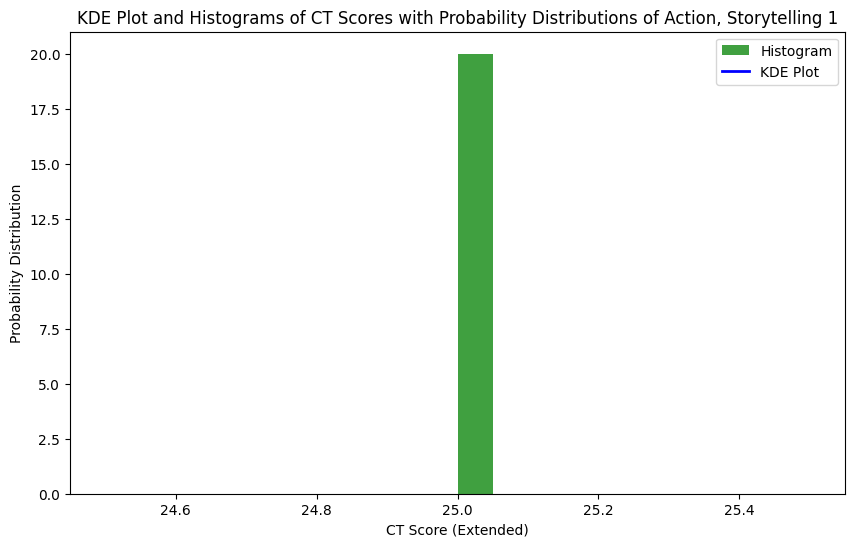

In [26]:
for name, df in main_genres_subsets.items():
    ct_score = df['points']
    
    # Gauss bell and save in a dataframe
    mean = ct_score.mean()
    std_dev = ct_score.std()
    min_score = ct_score.min()
    max_score = ct_score.max()
    x = np.linspace(min_score, max_score, 100)
    pdf = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
    
    
    plt.figure(figsize=(10, 6))
    
    # HISTOGRAM OF CT Score
    plt.hist(ct_score, density=True, color='green',bins=20, alpha=0.75, label='Histogram')
    
    # NORMAL DISTRIBUTION
    plt.plot(x, pdf, color='blue', linewidth=2, label='KDE Plot')
    
    
    # DESIGN
    plt.title(f"KDE Plot and Histograms of CT Scores with Probability Distributions of {name} {df.shape[0]}")
    plt.xlabel('CT Score (Extended)')
    plt.ylabel('Probability Distribution')
    plt.legend()
    
    
    plt.show()

#### 6.3.2. Second Genre

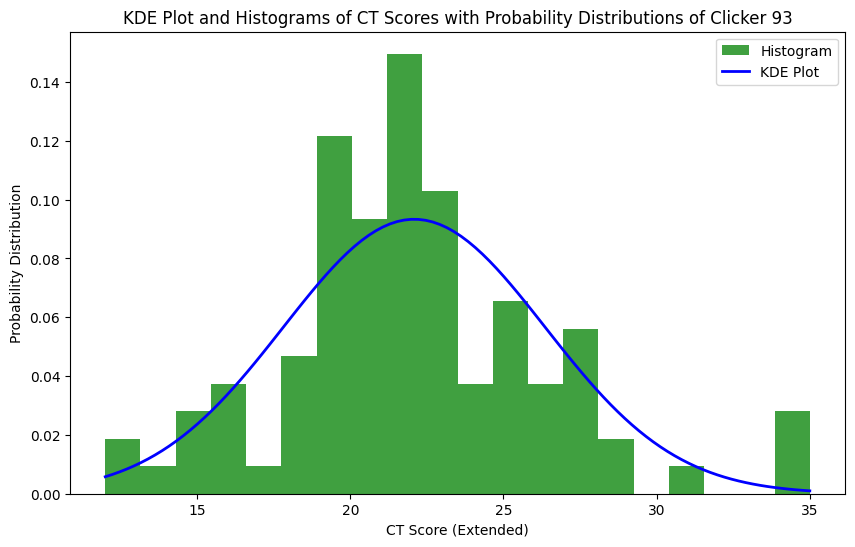

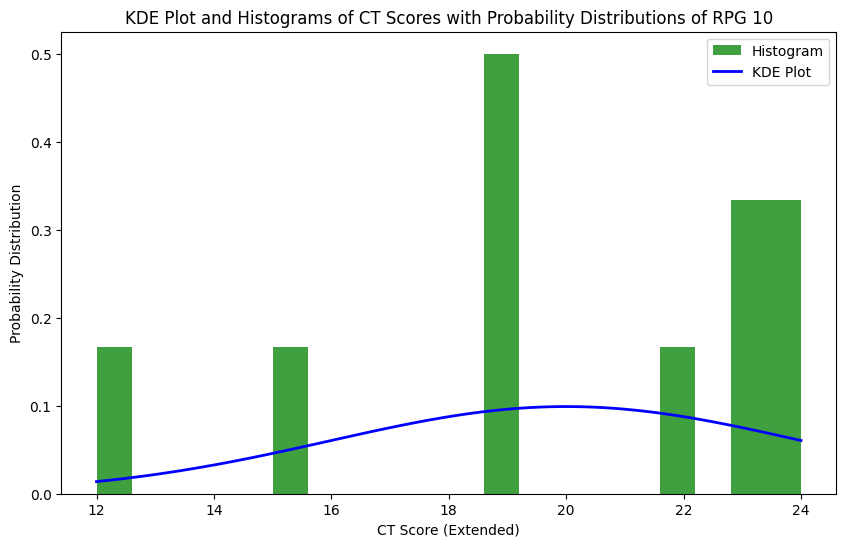

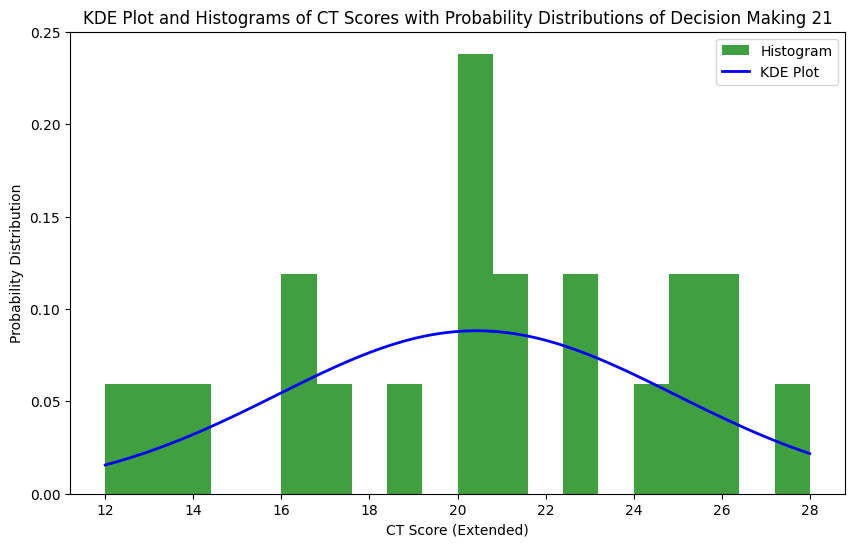

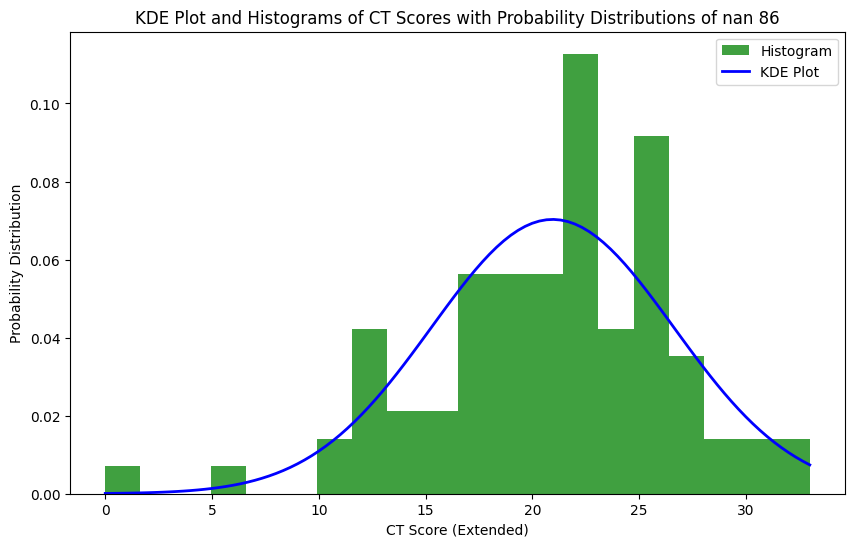

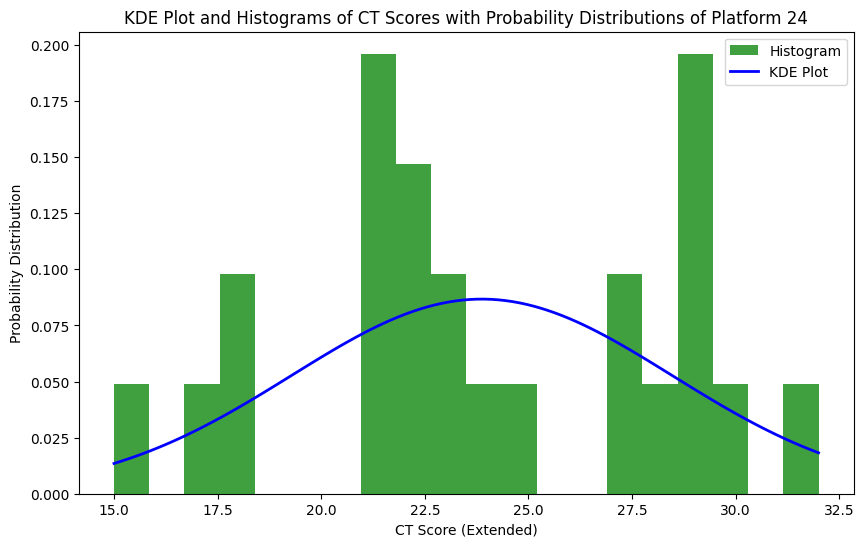

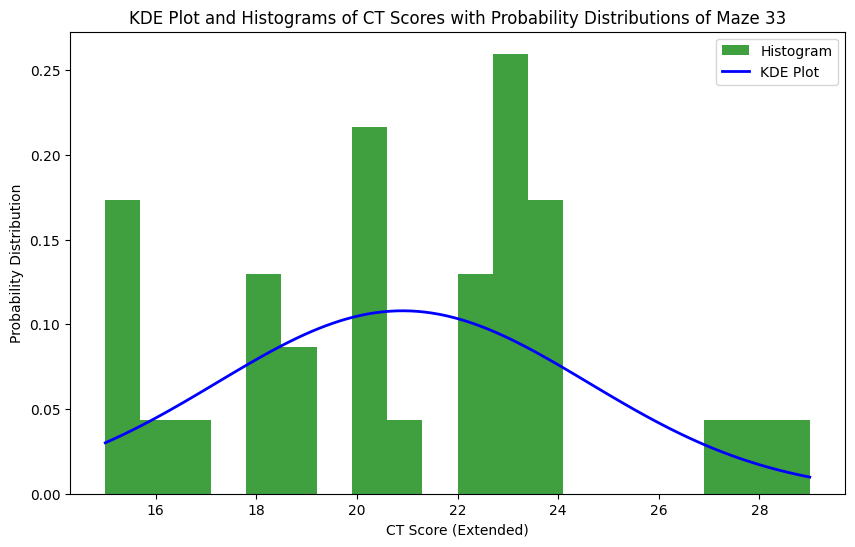

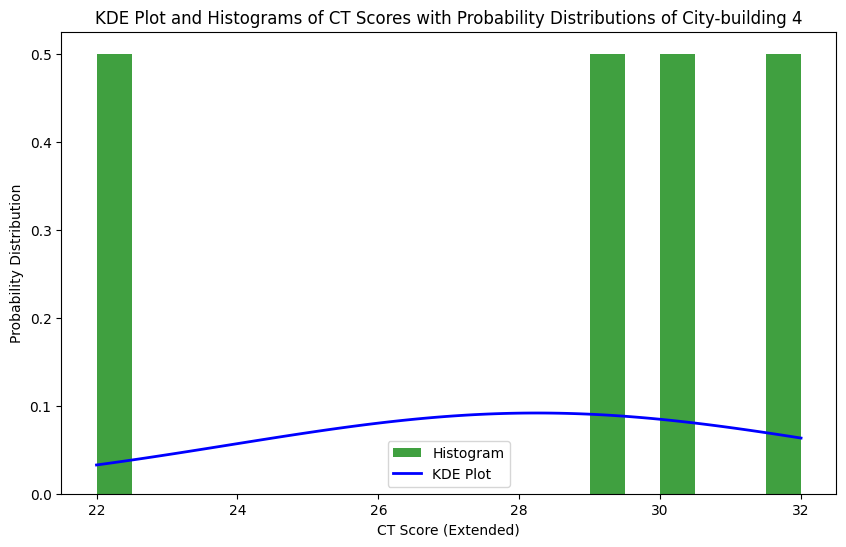

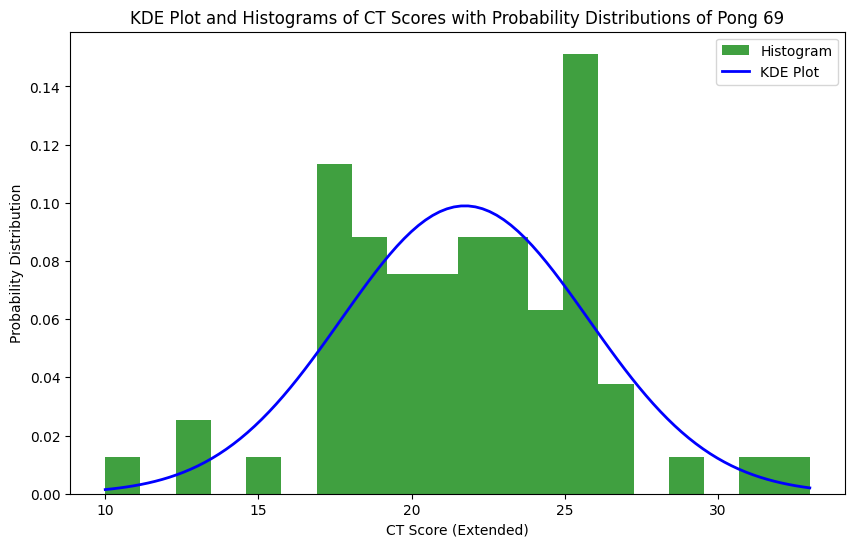

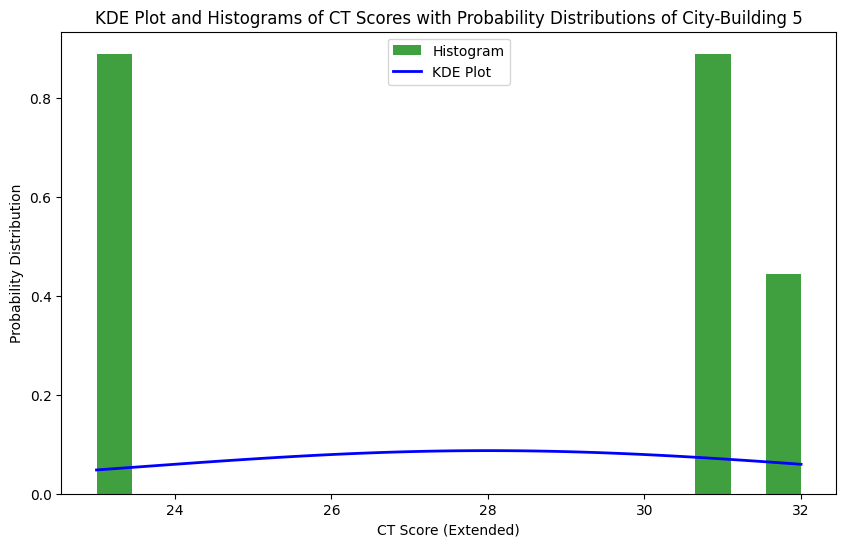

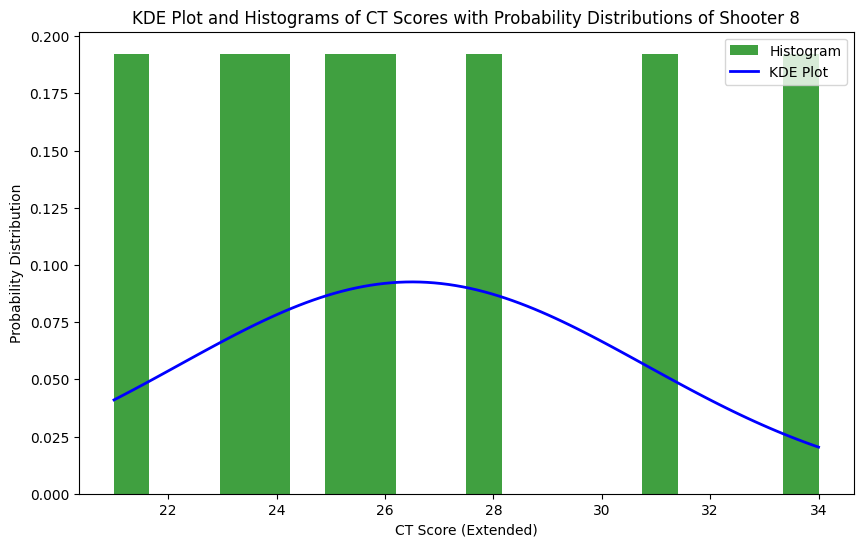

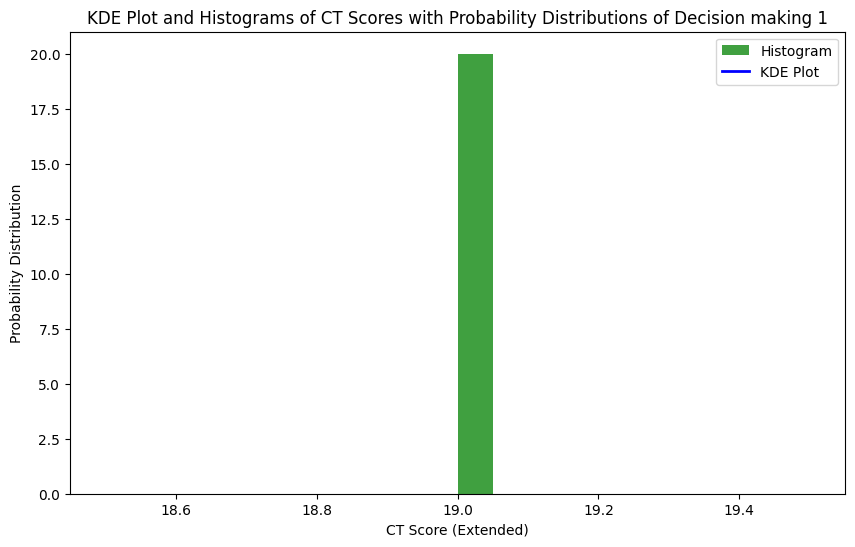

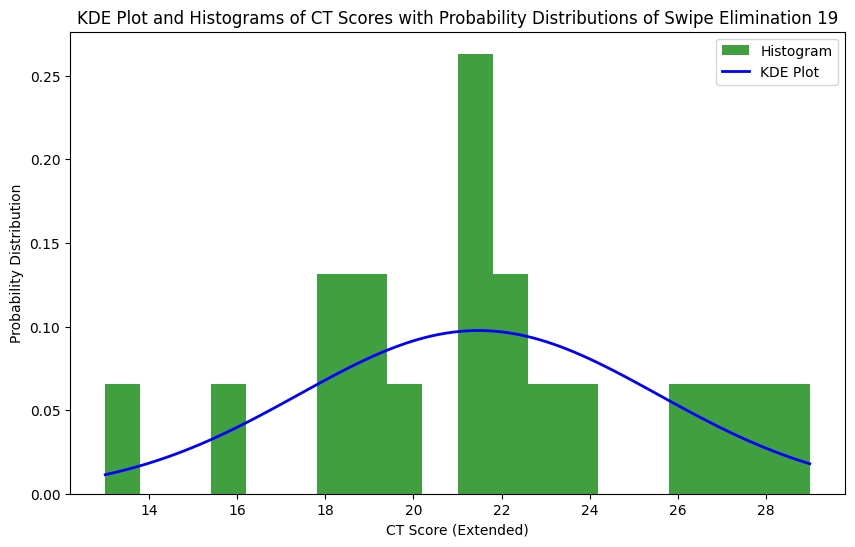

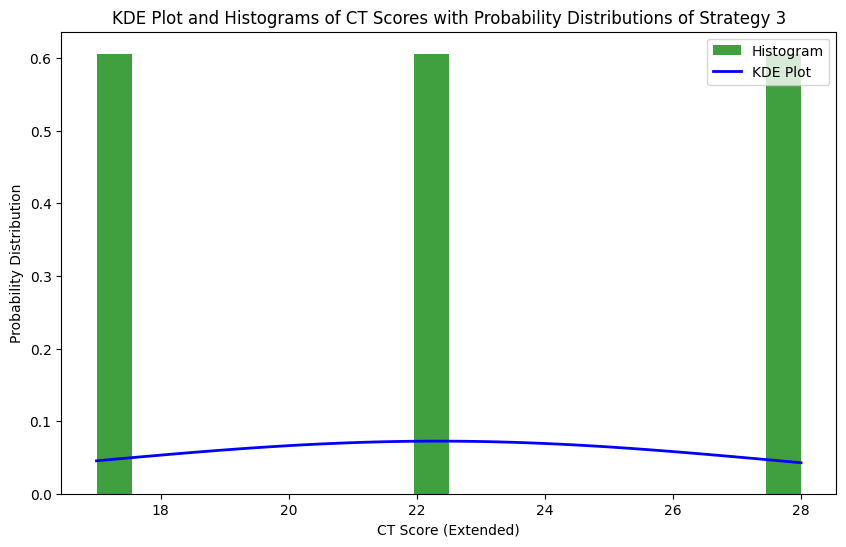

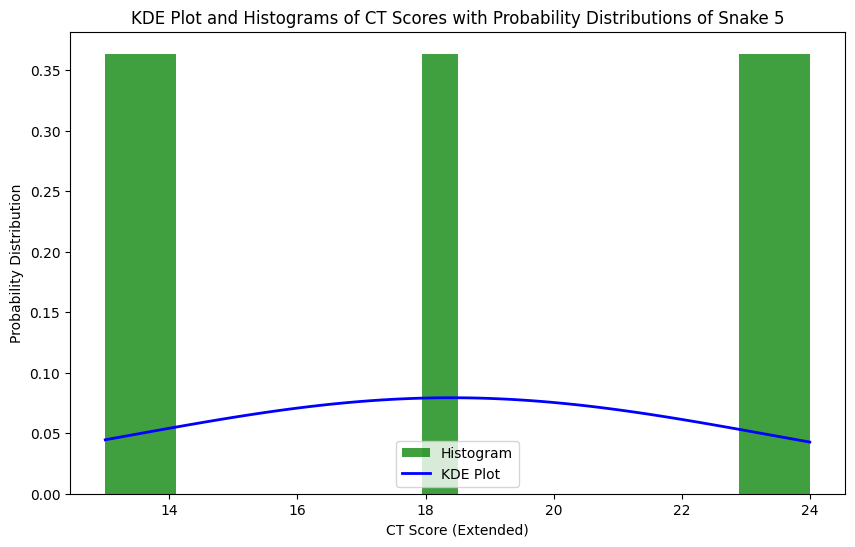

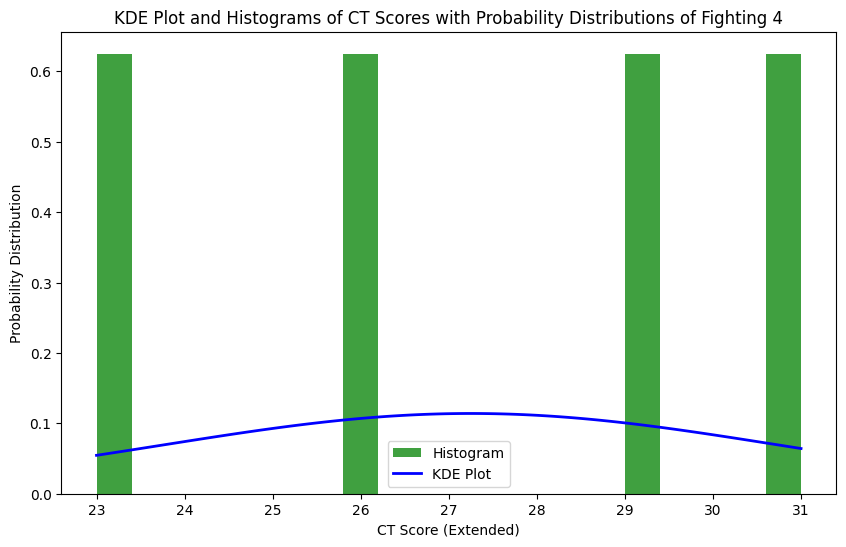

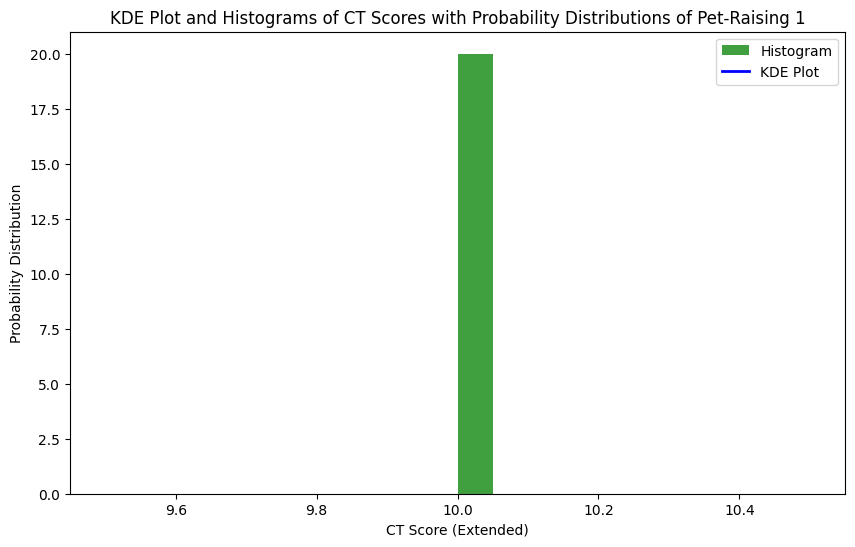

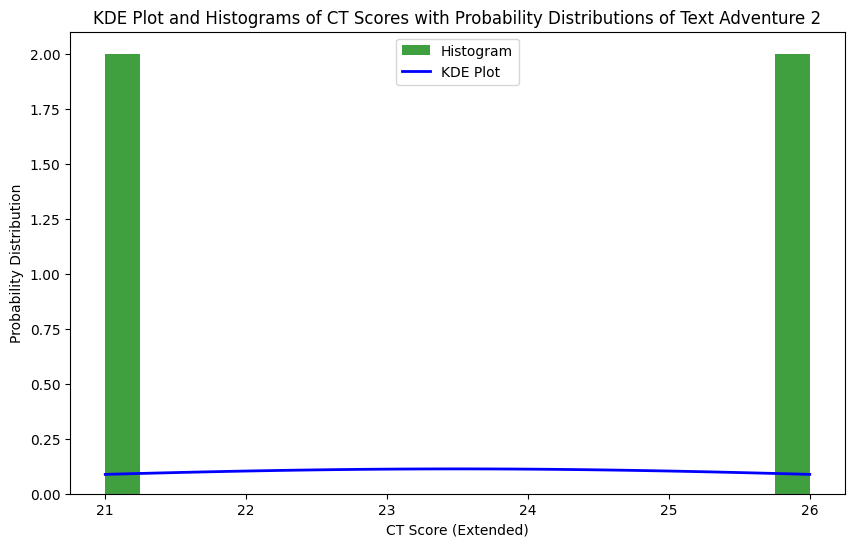

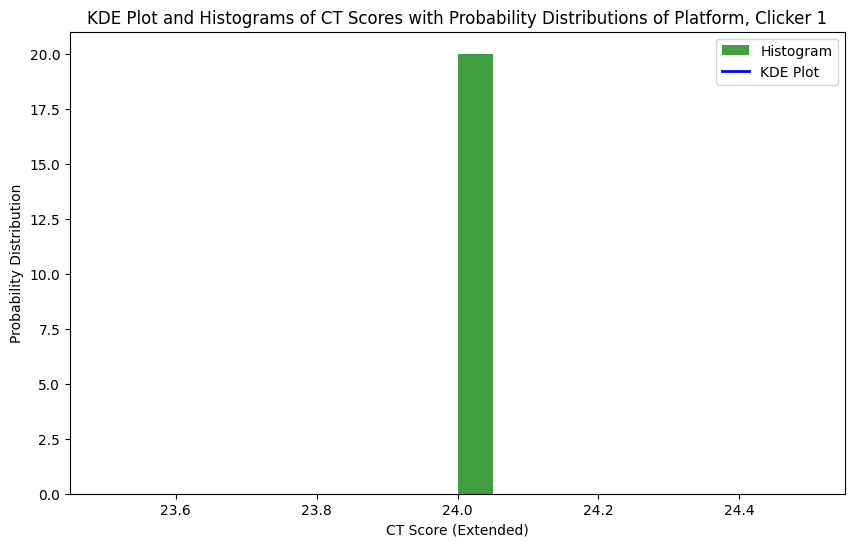

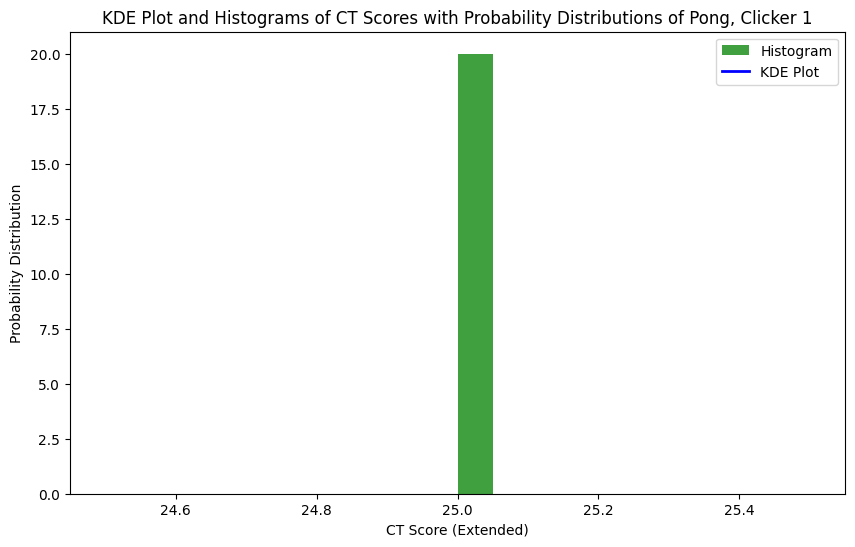

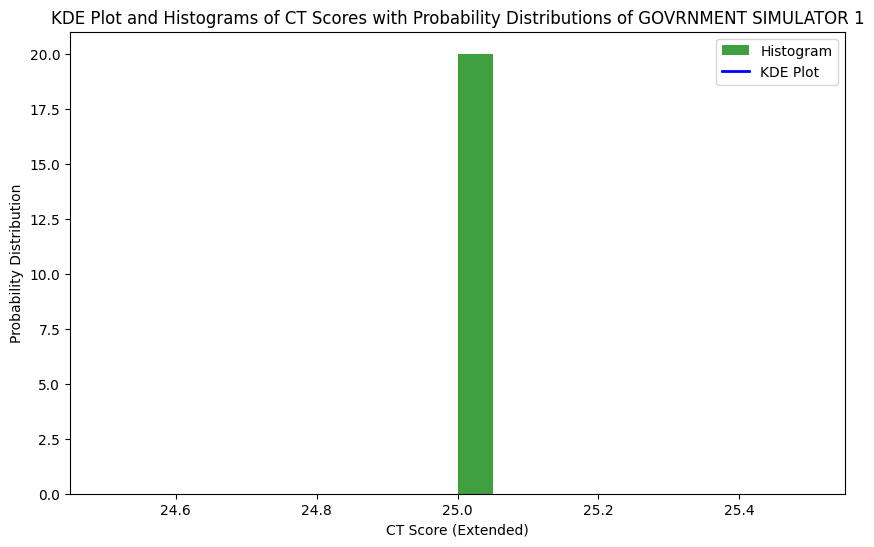

In [27]:
for name, df in second_genres_subsets.items():
    ct_score = df['points']
    
    # Gauss bell and save in a dataframe
    mean = ct_score.mean()
    std_dev = ct_score.std()
    min_score = ct_score.min()
    max_score = ct_score.max()
    x = np.linspace(min_score, max_score, 100)
    pdf = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
    
    
    plt.figure(figsize=(10, 6))
    
    # HISTOGRAM OF CT Score
    plt.hist(ct_score, density=True, color='green',bins=20, alpha=0.75, label='Histogram')
    
    # NORMAL DISTRIBUTION
    plt.plot(x, pdf, color='blue', linewidth=2, label='KDE Plot')
    
    
    # DESIGN
    plt.title(f"KDE Plot and Histograms of CT Scores with Probability Distributions of {name} {df.shape[0]}")
    plt.xlabel('CT Score (Extended)')
    plt.ylabel('Probability Distribution')
    plt.legend()
    
    
    plt.show()